# Mod 2 Project
Use multivariate linear regression to predict housing prices for the King County, WA Dataset

https://en.wikipedia.org/wiki/King_County,_Washington

https://www.kingcounty.gov/depts/assessor.aspx

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from haversine import haversine

## Read in Data

In [2]:
df = pd.read_csv('datasets/kc_house_data.csv')

## EDA

EDA was done in a separate notebook.  EDA.ipynb

Any pre-processing done during EDA is placed in the function below.

### pre-process data

based upon the datatype conversions, and NaN value processing above

In [3]:
def pre_process_data(data):
    """Convert String columns to numeric/data, and fill Nan values"""
    # type conversion
    data.loc[data.sqft_basement == '?', 'sqft_basement'] = '0'
    data.sqft_basement = data.sqft_basement.astype(float)
    
    data.date = pd.to_datetime(data.date)
    
    # fill Nan values
    data.waterfront.fillna(0.0, inplace=True)
    data.view.fillna(0.0, inplace=True)
    data.yr_renovated.fillna(0.0, inplace=True)
    
    # drop 'bad data'
    data.drop_duplicates(subset='id', keep='last', inplace=True)
    data.drop(data[data.bedrooms == 33].index, inplace=True)
    data.drop(data[data.id == 2991000160].index, inplace=True)
    
    return data

In [4]:
df_clean = pre_process_data(df)

#### Analysis

## New Continuous Features

### Distance from City Center

calculate the distance from the center of the major cities in King County and store the min distance

In [5]:
# calculate the distance from the center of the major cities in King County
df_clean['lat_long'] = tuple(zip(df_clean.lat, df_clean.long))
    
seattle = [47.6092,-122.3363]
bellevue = [47.61555,-122.20392]
kirkland = [47.6769, -122.2060]
redmond = [47.6740, -122.1215]

def calc_distances(lat_long, city):
    dists = []
    for loc in lat_long:
        dists.append(haversine((city),(loc),unit='mi'))
    return pd.Series(dists, index=df_clean.index)

df_clean['d_from_s'] = calc_distances(df_clean['lat_long'], seattle)
df_clean['d_from_b'] = calc_distances(df_clean['lat_long'], bellevue)
df_clean['d_from_k'] = calc_distances(df_clean['lat_long'], kirkland)
df_clean['d_from_r'] = calc_distances(df_clean['lat_long'], redmond)

df_clean['dist_from_city'] = df_clean[['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r']].min(axis=1, numeric_only=True)

df_clean.drop(['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r', 'lat_long'], axis=1, inplace=True)

### Age of house

In [6]:
def house_age(row):
    """
    Return the number of years in decimal between when the house was built 
    and when it was sold
    """
    # convert yr_built to date_time
    yr_built = pd.to_datetime(row['yr_built'], format='%Y')
    return (row['date'] - yr_built).days / 365


df_clean['house_age'] = df_clean.apply(house_age, axis=1)

In [7]:
df_clean.house_age.describe()

count    21418.000000
mean        43.763394
std         29.409853
min         -0.619178
25%         17.969178
50%         39.768493
75%         63.382877
max        115.435616
Name: house_age, dtype: float64

## Categorical Features

Normally the categorical features would be dealt with after a test train split has been done, but with the tools available for this project, it must be done before the split so that all the categories can be made.

### Category Helper Functions

In [8]:
def df_ohe(data, col, prefix=''):
    """
    Create One Hot Encoded (OHE) features for a column and 
    return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    """
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [9]:
def make_category(data, col):
    """
    Make a dataframe column a category and perform a One Hot Encoding on it,
    and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    
    """
    suffix='_encoded'
    lb_make = LabelEncoder()
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

In [10]:
def define_bins(data, col, num_quantiles):
    """
    Define bins for a dataframe column based on a number of quantiles
    
    Parameters:
    data: dataframe
    col: column to be binned
    num_quantiles: number of quantiles for binning
    """
    
    q_interval = 1 / num_quantiles
    print(q_interval)
    current_q = 0
    quantile_list = []
    
    for q in range(num_quantiles + 1):
        quantile_list.append(current_q)
        current_q = round(current_q + q_interval, 2)
    print(quantile_list)
    quantiles = data[col].quantile(quantile_list)
    
    return quantiles

In [11]:
def visualize_bins(data, col, quantiles):
    """
    Produce a histogram showing quantile splits
    
    Parameters:
    data: dataframe
    col: column
    quantiles: values for each quantile in col
    """
    fig, ax = plt.subplots()
    data[col].hist(bins='auto', color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)

In [12]:
def create_bins(data, col, bins):
    """
    Bin and One Hot Encode a dataframe column, and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column
    bins: array of where to split the data in col
    """
    
    col_binned = pd.cut(data[col], bins)
    binned_name = col+'_binned'
    data[binned_name] = col_binned
    data = data.drop(col, axis=1)
    data = df_ohe(data, binned_name, col)
    
    return data

### Simple Categories

In [13]:
simple_cat_data_cols = ['view','waterfront']

In [14]:
for col in simple_cat_data_cols:
    df_clean = make_category(df_clean, col)

### Complex Categories

#### yr_renovated and yr_built - had_reno

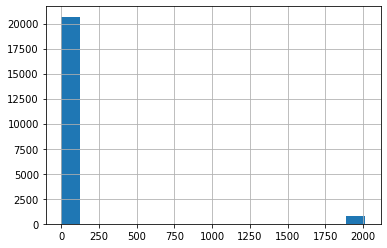

In [15]:
df_clean.yr_renovated.hist(bins='auto')

In [16]:
renovated_houses = df_clean[df_clean.yr_renovated >= df_clean.yr_built.min()]

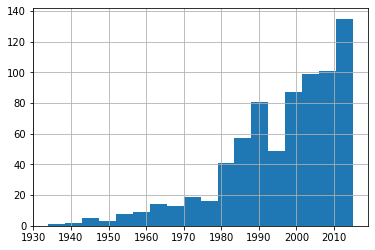

In [17]:
renovated_houses.yr_renovated.hist(bins='auto')

In [18]:
len(renovated_houses)

740

In [19]:
renovated_houses.id.nunique()

740

In [20]:
renovated_houses.id.value_counts()

2804100095    1
2131701075    1
1556200155    1
3179101580    1
3323069045    1
             ..
7950302890    1
6430000275    1
3450300280    1
9201000100    1
9297300480    1
Name: id, Length: 740, dtype: int64

There are very few renovated houses in the dataset, but it is potentially valuable info for those houses.

I will create a two new features
* yr_updated that will be the year built or the most recent renovation, which will be binned into 4 quantiles
* had_reno that will be a boolean indicating if a renovation ever occurred

yr_renovated and yr_built will not be included in the model

In [21]:
def had_reno(yr_renovated):
    """Return 0 if no renovation, 1 otherwise"""
    if yr_renovated == 0:
        return 0
    else:
        return 1

In [22]:
df_clean['had_reno'] = df_clean.yr_renovated.apply(had_reno)

In [23]:
df_clean = make_category(df_clean, 'had_reno')

In [24]:
def get_year_updated(row):
    """ Return the newer of yr_built or yr_renovated for a row"""
    if (row['yr_renovated'] == 0):
        year = row['yr_built']
    else:
        year = row['yr_renovated']
    
    return year

In [25]:
df_clean['yr_updated'] = df_clean.apply(get_year_updated, axis=1)

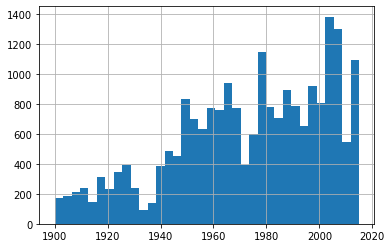

In [26]:
df_clean.yr_updated.hist(bins='auto')

In [27]:
yr_updated_bins = define_bins(df_clean, 'yr_updated', 4)

0.25
[0, 0.25, 0.5, 0.75, 1.0]


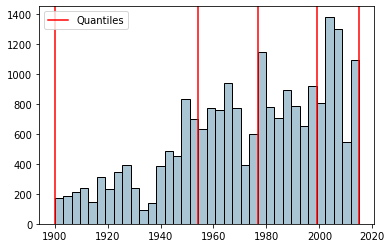

In [28]:
visualize_bins(df_clean, 'yr_updated', yr_updated_bins)

In [29]:
df_clean = create_bins(df_clean, 'yr_updated', yr_updated_bins)

#### Condition

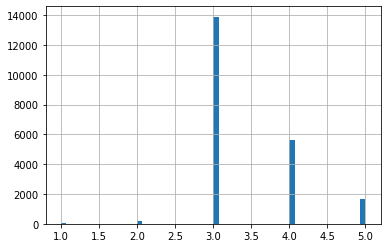

In [30]:
df_clean.condition.hist(bins='auto')

In [31]:
df_clean.condition.value_counts()

3    13899
4     5643
5     1686
2      162
1       28
Name: condition, dtype: int64

In [32]:
df_clean = df_ohe(df_clean, 'condition', 'condition')

#### zipcode

In [33]:
df_clean = df_ohe(df_clean, 'zipcode')

#### Latitude

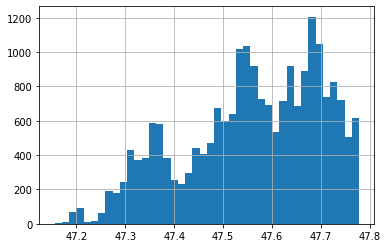

In [34]:
df_clean.lat.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


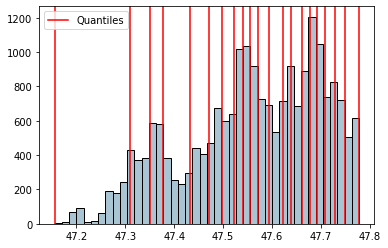

In [35]:
lat_bins = define_bins(df_clean, 'lat', 20)
visualize_bins(df_clean, 'lat', lat_bins)

In [36]:
# df_clean = create_bins(df_clean, 'lat', lat_bins)

#### Longitude

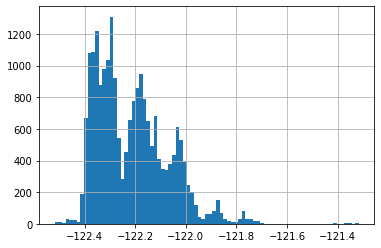

In [37]:
df_clean.long.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


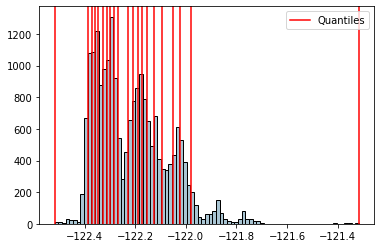

In [38]:
long_bins = define_bins(df_clean, 'long', 20)
visualize_bins(df_clean, 'long', long_bins)

In [39]:
# df_clean = create_bins(df_clean, 'long', long_bins)

#### Date - Season Sold

While the sale date does not have a correlation witht the sale price, 
it seems probable that houses on the waterfront would sell better in 
warmer months.

I will create a new feature called season by extracting it from the sale date.

In [40]:
df_clean['sale_month'] = df_clean.date.apply(lambda date: date.month)

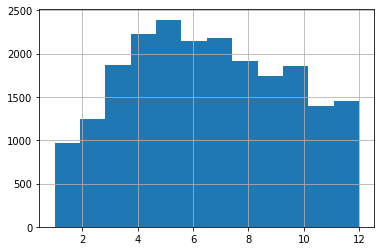

In [41]:
df_clean['sale_month'].hist(bins=12)

In [42]:
df_clean['sale_month'].value_counts()

5     2393
4     2229
7     2187
6     2150
8     1913
3     1875
10    1854
9     1747
12    1457
11    1396
2     1244
1      973
Name: sale_month, dtype: int64

In [43]:
def make_season(month):
    """Return a category value based on month"""
    winter = (11, 12, 1, 2)
    spring = (3, 4, 5, 6)
    summer = (7, 8, 9, 10)
    if month in winter:
        cat = 0
    elif month in spring:
        cat = 1
    else:
        cat = 2
        
    return cat

In [44]:
df_clean['season'] = df_clean.sale_month.apply(lambda month: make_season(month))

In [45]:
df_clean = make_category(df_clean, 'season')

In [46]:
df_clean = df_clean.drop('sale_month', axis=1)

#### Date - New Build

In [47]:
df_clean['year_sold'] = df_clean.date.apply(lambda date: date.year)

In [48]:
df_clean['new_build'] = df_clean['year_sold'] == df_clean['yr_built']

# drop uneeded temp column
df_clean = df_clean.drop('year_sold', axis=1)

In [49]:
df_clean = make_category(df_clean, 'new_build')

#### Floors - Split Level Flag

In [50]:
def in_split_level(floors):
    """Return whether the number of floors indicates a split level house"""
    split_levels = {1.5, 2.5, 3.5}
    if floors in split_levels:
        return 0
    else:
        return 1

df_clean['split_level'] = df_clean.floors.apply(in_split_level)


In [51]:
df_clean = make_category(df_clean, 'split_level')

#### sqft_basement - Flag

In [52]:
def has_basement(sqft_basement):
    """Return whether the house has a basement"""
    if sqft_basement == 0.0:
        return 0
    else:
        return 1

df_clean['has_basement'] = df_clean.sqft_basement.apply(has_basement)

df_clean = make_category(df_clean, 'has_basement')


## Model Helper Functions

In [53]:
def lin_reg_sklearn(X_train, X_test, y_train, y_test, drop_list=[]):
    """
    Perform a Linear Regression with SK Learn and output 
    RMSE from the test and training sets, plus a cross validation of the training set.
    """
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print(f'Training Set RMSE: {np.sqrt(train_mse)}')
    print(f'Test Set RMSE: {np.sqrt(test_mse)}')

    MSE = make_scorer(mean_squared_error)

    cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X_train, 
                                                    y_train, cv=10,
                                                   scoring=MSE)))
    print(f'Cross Val RMSE: {cv_rmse}')

In [54]:
def lin_reg_statsmodels(X_train, y_train, drop_list=[]):
    """
    Perform a Linear Regression with Statsmodels, output the summary and
    return the model
    """
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
    display(model.summary())
    
    return model

In [55]:
def drop_features(X_train, X_test, drop_list):
    """
    Drop features in the drop_list from the two dataframes and return
    the two updated dataframes
    """
    if len(drop_list) >= 1:
        X_train = X_train.drop(drop_list, axis=1)
        X_test = X_test.drop(drop_list, axis=1)
    
    return X_train, X_test

In [56]:
def regression_plots(data, model):
    """Regression plots for the features in the data dataframe based on the model"""
    for col in data.columns:
        fig = plt.figure(figsize=(16,12))
        sm.graphics.plot_regress_exog(model, col, fig=fig)
        fig.show()

In [57]:
def vif_analysis(data):
    """VIF analysis on the data dataframe"""
    for i in range(len(data.columns)):
        v=vif(np.matrix(data),i)
        print("Variance inflation factor for {}: {}".format(data.columns[i],round(v,2)))

In [58]:
def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
    
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    senter : Significance Level to be Selected in Forward Selection (default: 0.05)\n
    sstay : Significance Level to be Stayed in Backward Elimination (default: 0.05)\n
  
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """  
    
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    

            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):
                
                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])

 
                for l in cols_backward:
                    pvals_backward = pvals_backward.append(pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"]),ignore_index=True)
                    
                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:
                    
                    
                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n") 
                        
                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                    
                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                           
                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"     
        
           
                else:
                    print("break : No need to Backward Elimination")
                    break
            
            
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
            
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)
    

    iterations_log += "\nFinal Selection and Model Statistics\n"
    
    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m]) 
           
    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log

## Split the Data into train/test

In [59]:
y = df_clean.price
X = df_clean.drop('price', axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Drop Outliers in Training Data

In [61]:
def drop_outliers(data, col, n_std):
    return data[np.abs(data[col]-data[col].mean())<=(n_std*data[col].std())]

In [62]:
def outlier_val(data, col, n_std):
    return n_std*data[col].std()

## Simple Model

This will be the baseline model.  It will contain all of the continuous 
numerical features, but no others.

### Define feature sets

In [63]:
cont_data_cols = ['bathrooms', 'bedrooms', 'sqft_above', 'sqft_living15', 
                 'sqft_lot', 'sqft_lot15', 'floors', 'grade', 'dist_from_city', 'house_age']

In [64]:
X_train_cont_features = X_train[cont_data_cols]
X_test_cont_features = X_test[cont_data_cols]

### Linear Regression sklearn

In [65]:
lin_reg_sklearn(X_train_cont_features, X_test_cont_features, y_train, y_test)

Training Set RMSE: 216687.4103999934
Test Set RMSE: 216493.29951934112
Cross Val RMSE: 217117.38865500406


### Linear Regression statsmodels

In [66]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3197.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:28:34   Log-Likelihood:            -2.3482e+05
No. Observations:               17134   AIC:                         4.697e+05
Df Residuals:                   17123   BIC:                         4.698e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.672e+05   1.86e+04    -41.293      0.000   -8.04e+05   -7.31e+05
bathrooms       1.067e+05   3521.458     30.307      0.000    9.98e+04    1.14e+05
bedrooms        -2.53e+04   2289.592    -11.051      0.000   -2.98e+04   -2.08e+04
sqft_above       123.1715      3.965     31.062      0.000     115.399     130.944
sqft_living15     55.2424      3.922     14.084      0.000      47.554      62.931
sqft_lot           0.2309      0.060      3.837      0.000       0.113       0.349
sqft_lot15        -0.0021      0.089     -0.023      0.982      -0.177       0.173
floors         -4.424e+04   4074.806    -10.857      0.000   -5.22e+04   -3.63e+04
grade           1.155e+05   2529.986     45.637      0.000    1.11e+05     1.2e+05
dist_from_city -1.572e+04    283.602    -55.440      0.000   -1.63e+04   -1.52e+04
house_age       3443.1845     74.373     46.296      0.000    3297.405    3588.964
==============================================================================
Omnibus:                    17569.761   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2853235.166
Skew:                           4.746   Prob(JB):                         0.00
Kurtosis:                      65.502   Cond. No.                     5.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

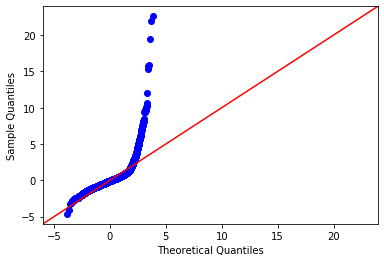

In [67]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);

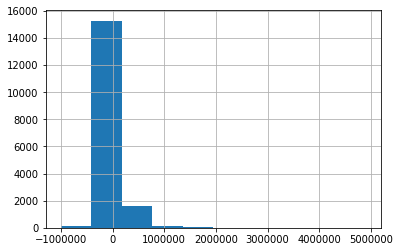

In [68]:
model_cont_features.resid.hist()

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


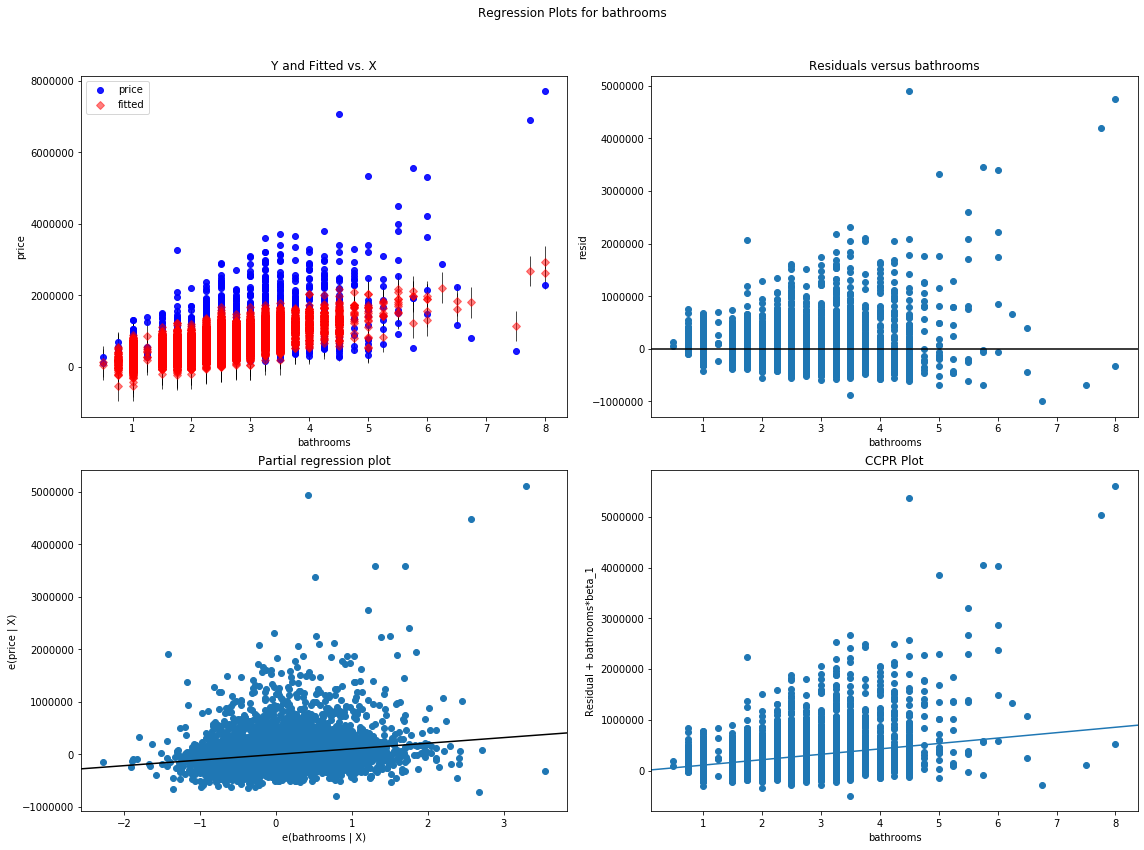

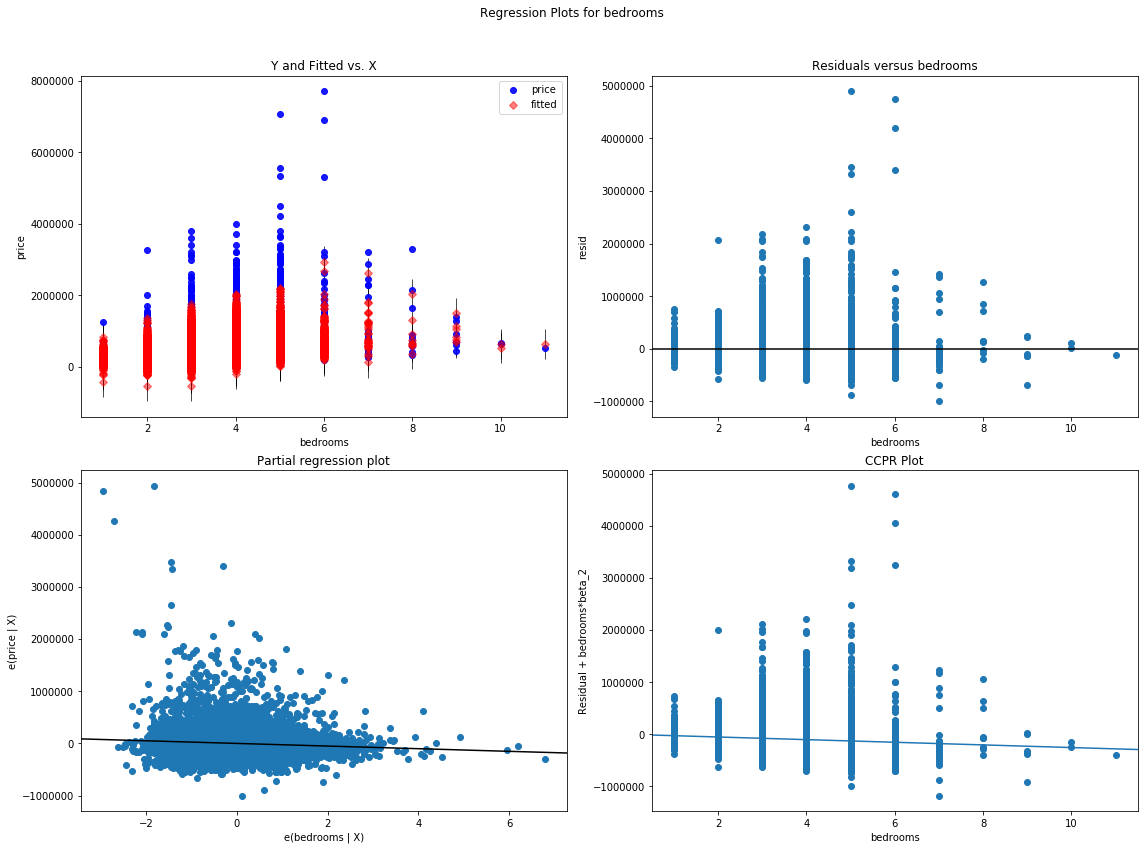

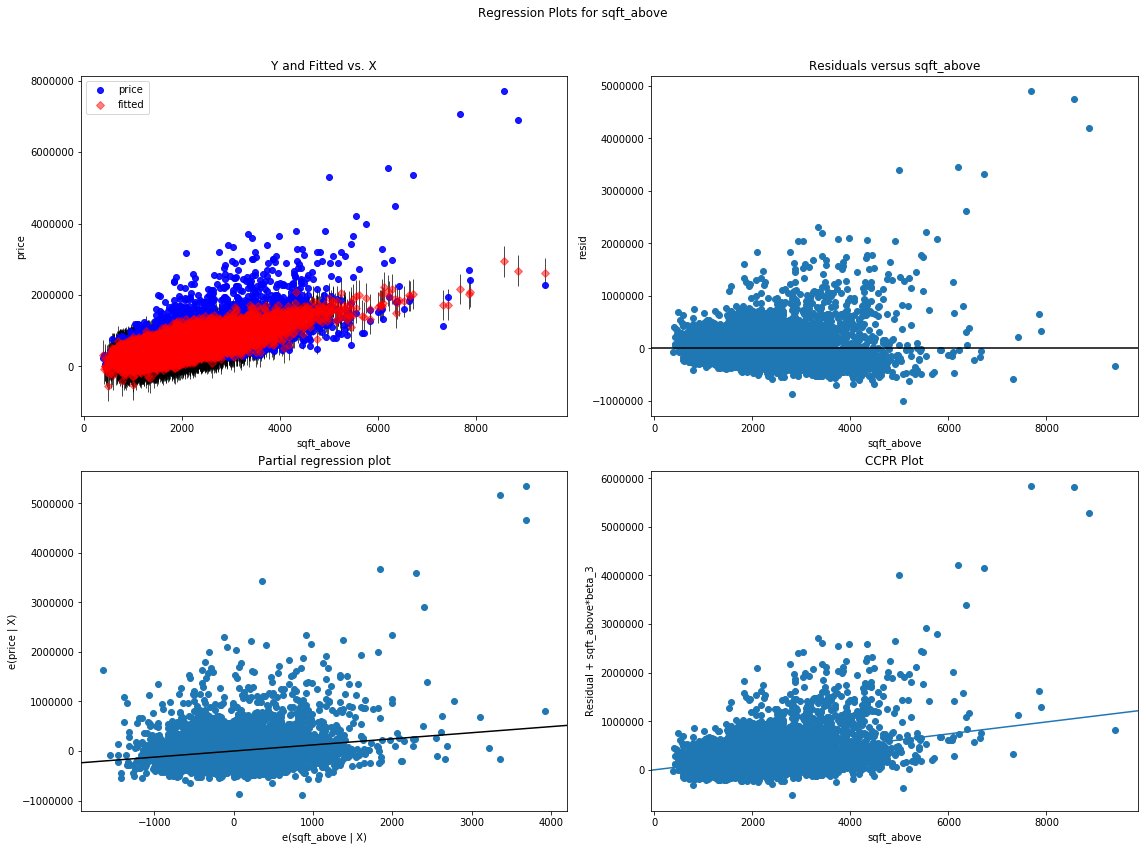

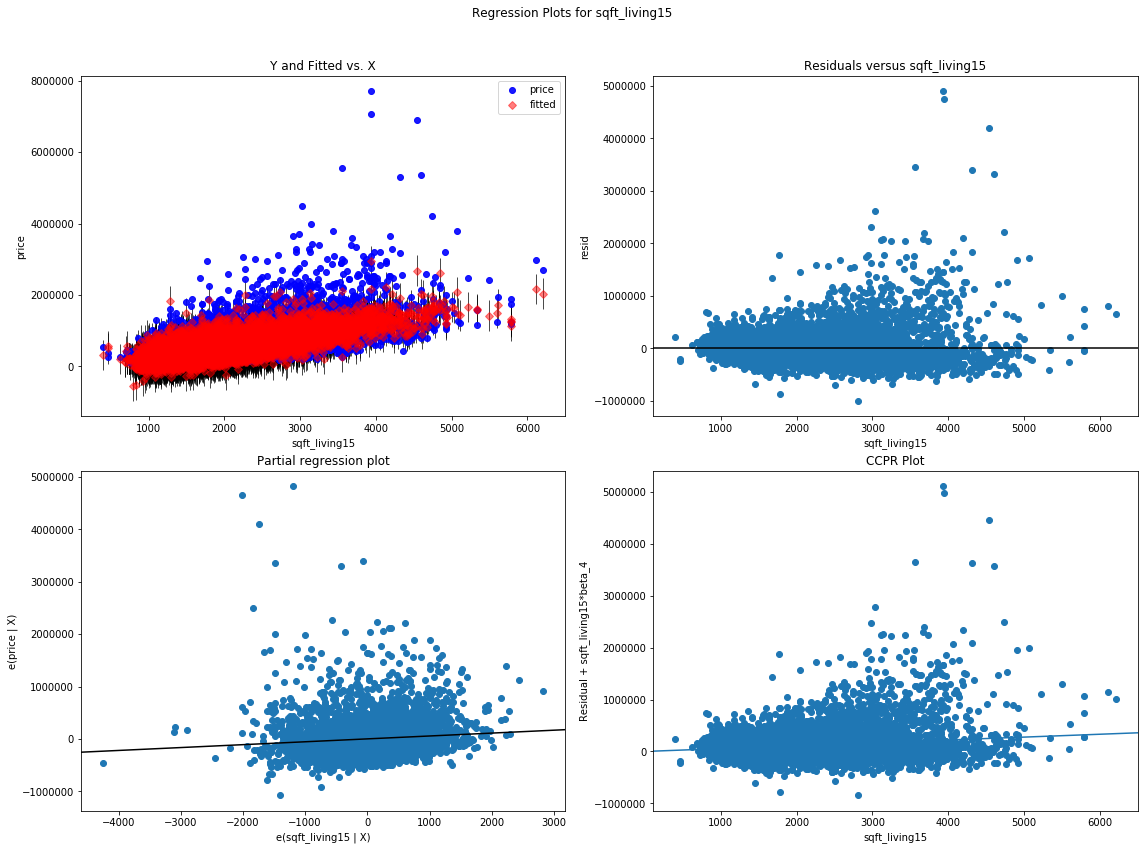

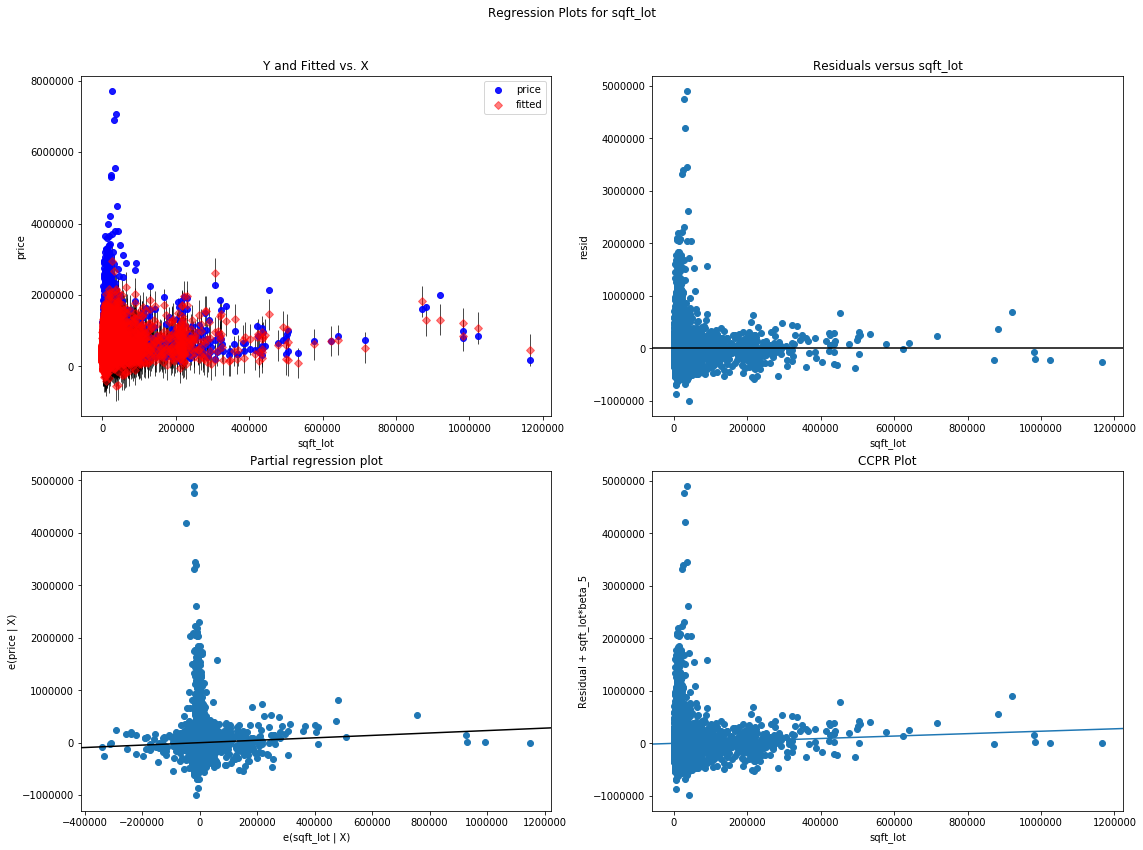

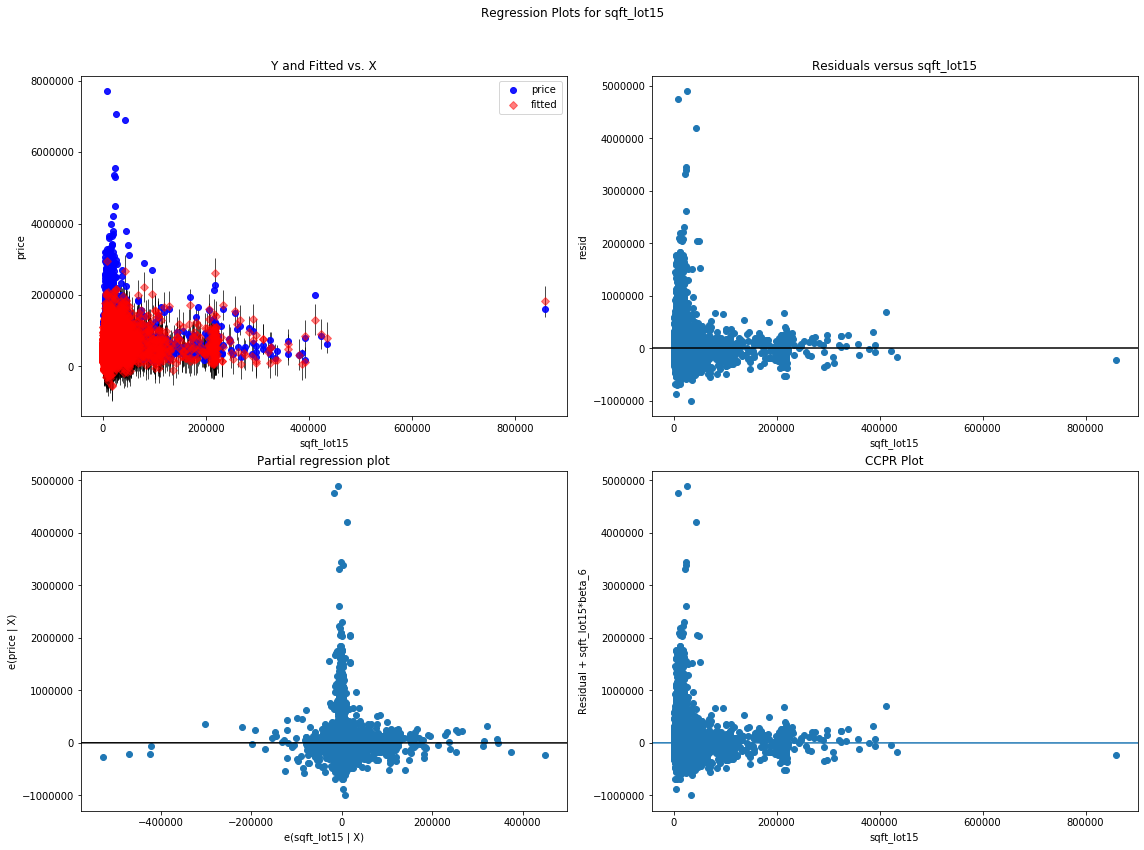

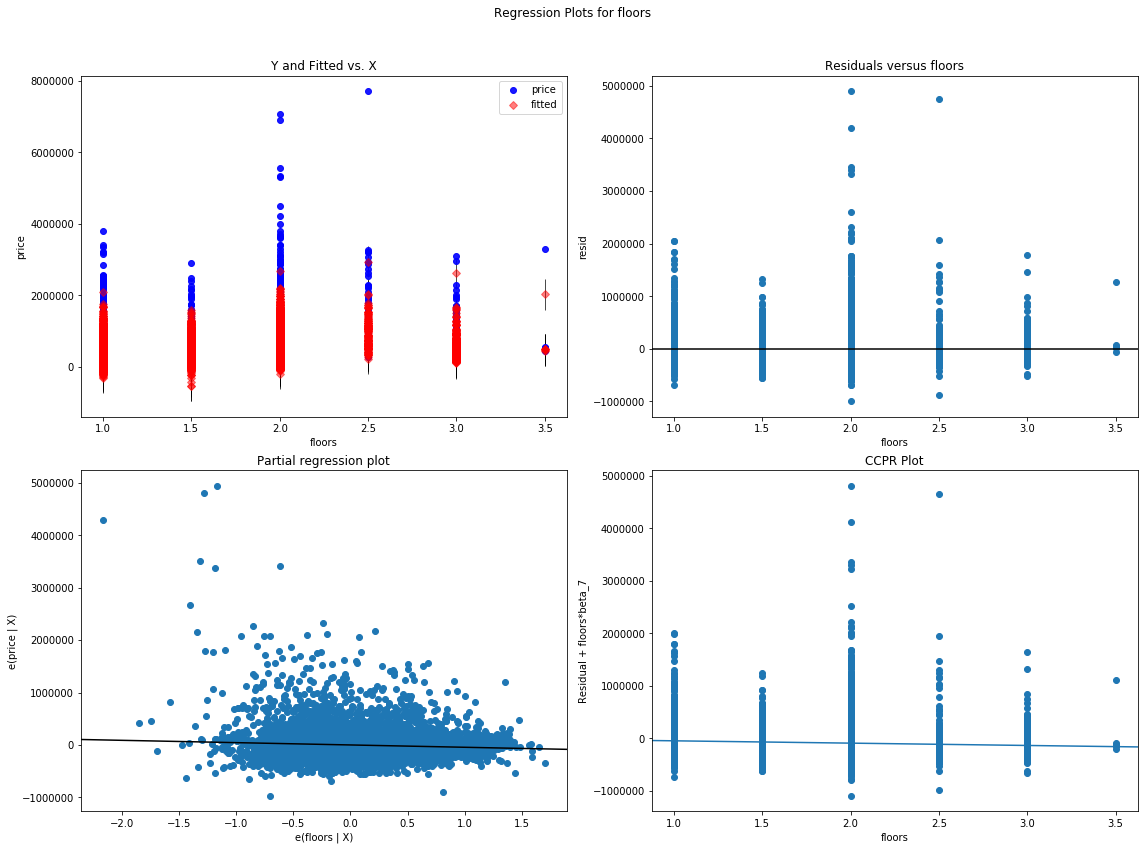

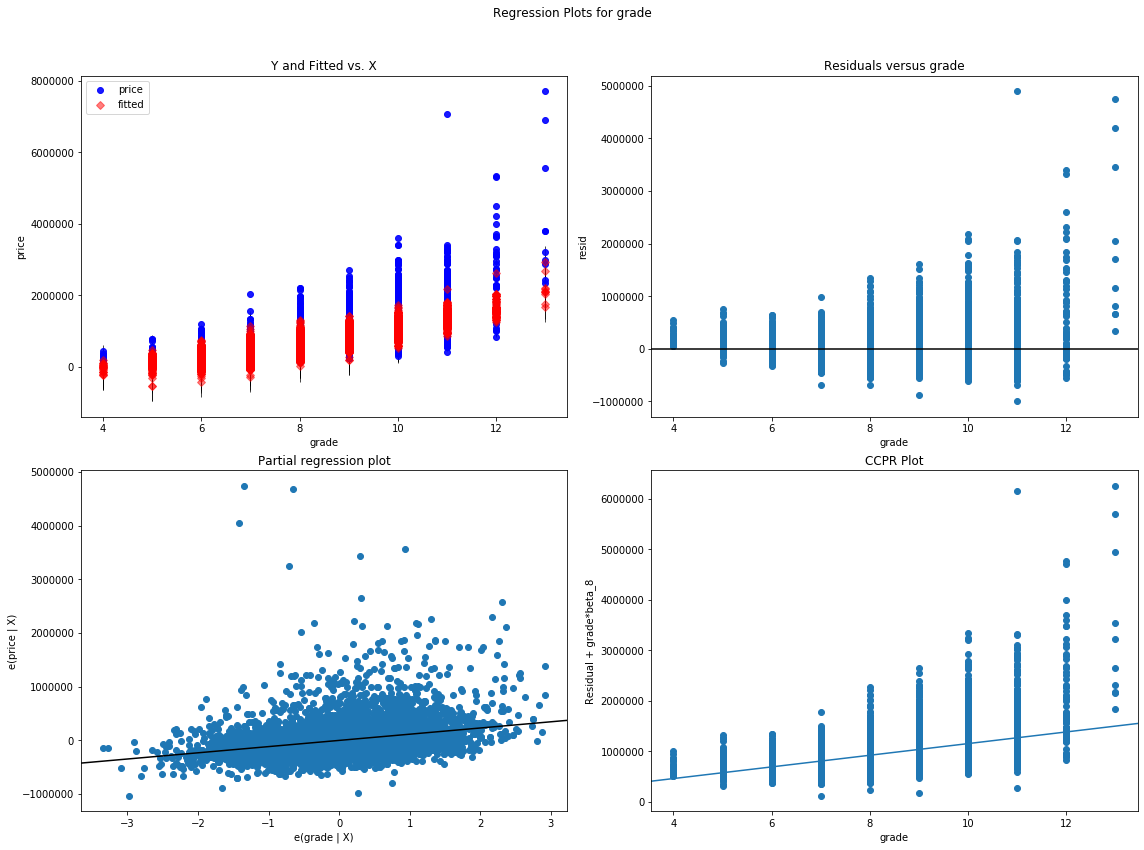

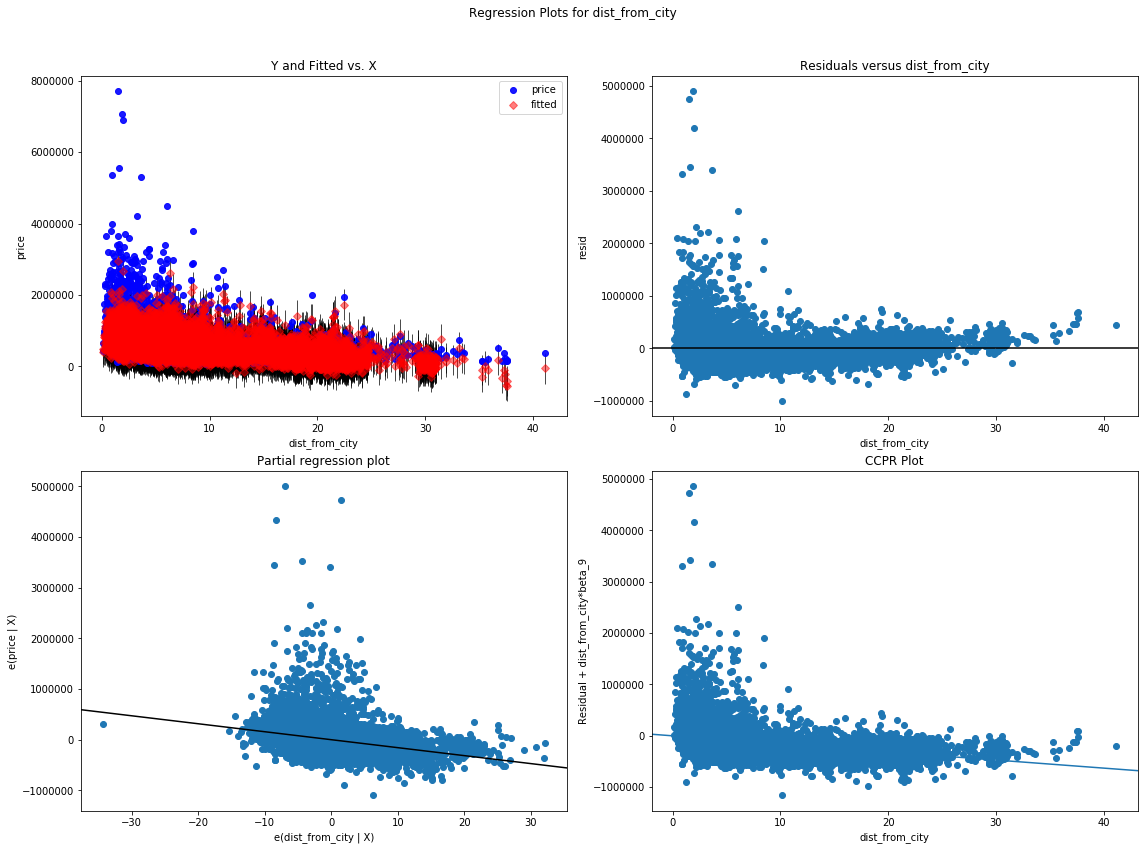

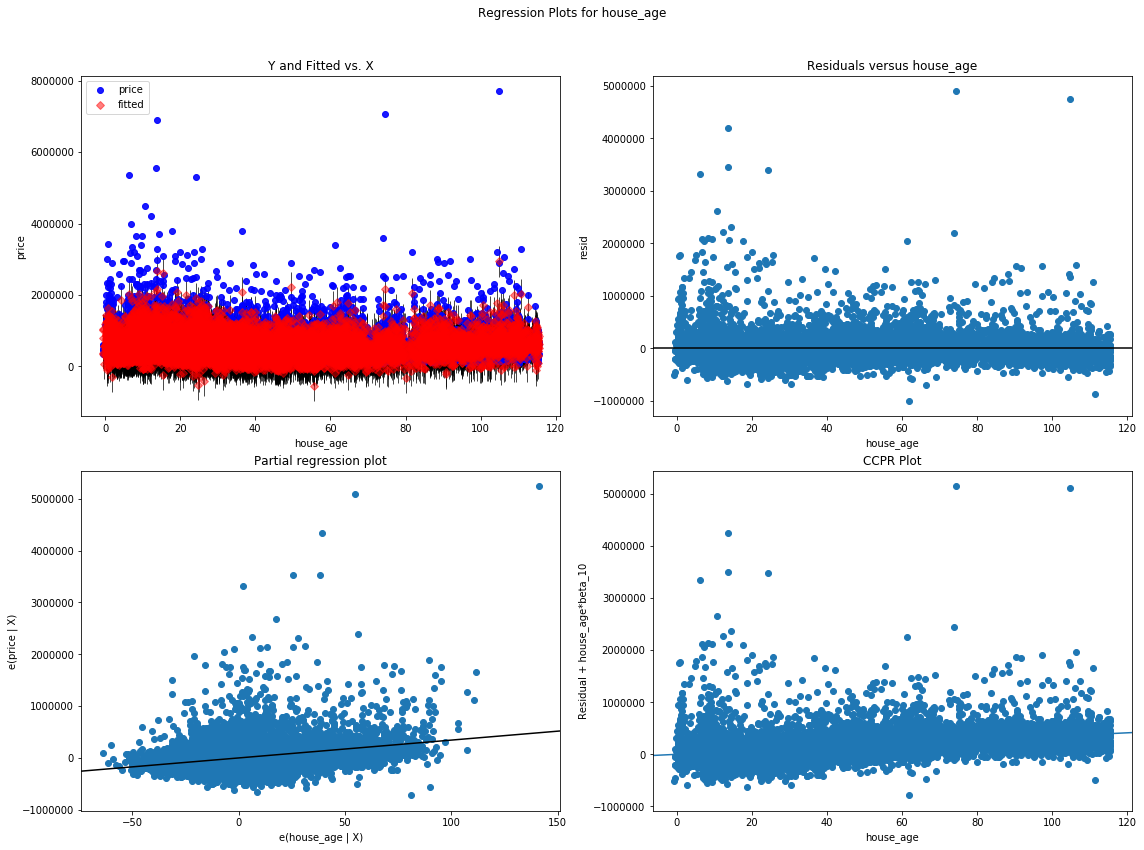

In [69]:
for col in X_train_cont_features.columns:
    fig = plt.figure(figsize=(16,12))
    sm.graphics.plot_regress_exog(model_cont_features, col, fig=fig)
    fig.show()

In [70]:
for i in range(len(X_train_cont_features.columns)):
    v=vif(np.matrix(X_train_cont_features),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features.columns[i],round(v,2)))

Variance inflation factor for bathrooms: 23.0
Variance inflation factor for bedrooms: 21.35
Variance inflation factor for sqft_above: 17.95
Variance inflation factor for sqft_living15: 24.87
Variance inflation factor for sqft_lot: 2.36
Variance inflation factor for sqft_lot15: 2.55
Variance inflation factor for floors: 13.77
Variance inflation factor for grade: 54.66
Variance inflation factor for dist_from_city: 2.76
Variance inflation factor for house_age: 3.96


In [71]:
X_train_cont_features.corr()

,bathrooms,bedrooms,sqft_above,sqft_living15,sqft_lot,sqft_lot15,floors,grade,dist_from_city,house_age
bathrooms,1.000000,0.532063,0.688910,0.569046,0.100348,0.091730,0.499065,0.666160,-0.028157,-0.509343
bedrooms,0.532063,1.000000,0.499119,0.407847,0.037266,0.033978,0.185782,0.370765,-0.005801,-0.169031
sqft_above,0.688910,0.499119,1.000000,0.731819,0.200206,0.198301,0.518443,0.755877,0.023473,-0.425652
sqft_living15,0.569046,0.407847,0.731819,1.000000,0.147943,0.181626,0.273876,0.712445,-0.053585,-0.329407
sqft_lot,0.100348,0.037266,0.200206,0.147943,1.000000,0.711521,-0.002144,0.125897,0.169266,-0.060650
sqft_lot15,0.091730,0.033978,0.198301,0.181626,0.711521,1.000000,-0.012872,0.118662,0.184512,-0.070169
floors,0.499065,0.185782,0.518443,0.273876,-0.002144,-0.012872,1.000000,0.454715,-0.041096,-0.492187
grade,0.666160,0.370765,0.755877,0.712445,0.125897,0.118662,0.454715,1.000000,-0.133004,-0.451177
dist_from_city,-0.028157,-0.005801,0.023473,-0.053585,0.169266,0.184512,-0.041096,-0.133004,1.000000,-0.222323
house_age,-0.509343,-0.169031,-0.425652,-0.329407,-0.060650,-0.070169,-0.492187,-0.451177,-0.222323,1.000000


### Summary

Baseline model

The residuals do not have a normal distribution, they are skewed to the right, and have heavy tails, as is shown in the q-q plot and the histogram.

From the Regression Plots we learned:

bathrooms
* correlated with target
* residuals are somewhat homoskedastic

bedrooms
* not correlated with target over all its values, only up to 5
* residuals are not homeskedastic

sqft_living
* correlated with target
* residuals are not homoskedastic.  They are close to the mean when the var is low and increase from there. **Might improve if the highest value is dropped.**

sqft_living15
* correlated with target
* residuals are somewhat homoskedastic.

sqft_lot
* not correlated with target
* residuals are not homoskedastic
* doesn't do well with small lot sizes and high prices, which would be urban settings, maybe an interaction would help

sqft_lot15
* not correlated with target
* residuals are not homoskedastic
* similar to sqft_lot

floors
* not well correlated with the target
* residuals are somewhat homoskedastic
* split levels and large 3+ floor houses cause problems.

grade
* correlated with the target
* residuals are not homoskedastic, they increase as grade increases.  May be a good candidate to be a polynomial feature

d_from_city
* negative correlation with the target, but not well for low values
* residuals are homoskedastic except for the low values

From the VIF report and the correlation report we can see that there are significant multicolinearity issues that need to be dealt with.  I will standardize the affected features and rerun the regression below.

Using a cutoff of 0.7 in the correlation matrix, the affected features are:
* bathrooms
* sqft_living
* grade
* sqft_living15

The VIF report also includes the following:
* floors
* bedrooms

Standardizing the features around 0 will maintain their interpretability while potentially dealing with the multicolinearity issues.

## Data Cleaning of Features in Simple Model

### Drop Outliers / Bad Data

Drop the highest value from the sqft_living column

In [72]:
index = df_clean[df_clean.sqft_living == 13540].index

X_train = X_train.drop(index)
y_train = y_train.drop(index)

### Standardize the features with multicolinearity issues

In [73]:
m_cols = ['bathrooms', 'sqft_above', 'sqft_living15', 'grade', 'floors', 'bedrooms']
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_train[scaled_col_name] = scale(X_train[col])

In [74]:
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_test[scaled_col_name] = scale(X_test[col])

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages

## Rerun simple model

The simple model was rerun with the new standardizations several times to get the best R^2, RMSE and least multicolinearity issues.

In the baseline model, sqft_lot had a high p-value, but it performed better after the above standardizations, so it was kept.

Two features still showed multicolinearity problems so they were dropped:
* sqft_living_scaled
* floors_scaled

One feature ended up with a high p-value and was dropped
* bedrooms_scaled


### Define Feature Sets

In [75]:
cont_data_cols2 = ['bathrooms_scaled', 
                   #'bedrooms_scaled', 
                   'sqft_above_scaled', 
                   'sqft_living15_scaled', 
                   'sqft_lot', 
                   #'sqft_lot15', 
                   #'floors_scaled',
                   'grade_scaled',
                  'dist_from_city',
                  'house_age']

In [76]:
X_train_cont_features_rerun = X_train[cont_data_cols2]
X_test_cont_features_rerun = X_test[cont_data_cols2]

### Linear Regression sklearn

In [77]:
lin_reg_sklearn(X_train_cont_features_rerun, X_test_cont_features_rerun, y_train, y_test)

Training Set RMSE: 218026.22037816962
Test Set RMSE: 218331.93580628032
Cross Val RMSE: 218373.25121653828


### Linear Regression statsmodels

In [78]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     4473.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:28:57   Log-Likelihood:            -2.3492e+05
No. Observations:               17133   AIC:                         4.698e+05
Df Residuals:                   17125   BIC:                         4.699e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.136e+05   4753.744    108.042      0.000    5.04e+05    5.23e+05
bathrooms_scaled      6.849e+04   2525.902     27.117      0.000    6.35e+04    7.34e+04
sqft_above_scaled       8.4e+04   3045.912     27.578      0.000     7.8e+04       9e+04
sqft_living15_scaled  4.308e+04   2622.904     16.423      0.000    3.79e+04    4.82e+04
sqft_lot                 0.3132      0.044      7.145      0.000       0.227       0.399
grade_scaled          1.369e+05   2965.967     46.144      0.000    1.31e+05    1.43e+05
dist_from_city       -1.542e+04    281.748    -54.743      0.000    -1.6e+04   -1.49e+04
house_age             3576.7639     70.534     50.710      0.000    3438.511    3715.017
==============================================================================
Omnibus:                    18018.191   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3208949.229
Skew:                           4.934   Prob(JB):                         0.00
Kurtosis:                      69.315   Cond. No.                     1.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check for Multicolinearity

In [79]:
for i in range(len(X_train_cont_features_rerun.columns)):
    v=vif(np.matrix(X_train_cont_features_rerun),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features_rerun.columns[i],round(v,2)))

Variance inflation factor for bathrooms_scaled: 2.17
Variance inflation factor for sqft_above_scaled: 3.32
Variance inflation factor for sqft_living15_scaled: 2.48
Variance inflation factor for sqft_lot: 1.23
Variance inflation factor for grade_scaled: 2.95
Variance inflation factor for dist_from_city: 1.74
Variance inflation factor for house_age: 1.78


In [80]:
X_train_cont_features_rerun.corr()

,bathrooms_scaled,sqft_above_scaled,sqft_living15_scaled,sqft_lot,grade_scaled,dist_from_city,house_age
bathrooms_scaled,1.000000,0.687684,0.568449,0.097372,0.665911,-0.028042,-0.509795
sqft_above_scaled,0.687684,1.000000,0.731761,0.197042,0.756055,0.023726,-0.426195
sqft_living15_scaled,0.568449,0.731761,1.000000,0.146455,0.712191,-0.053524,-0.329349
sqft_lot,0.097372,0.197042,0.146455,1.000000,0.124546,0.169696,-0.060333
grade_scaled,0.665911,0.756055,0.712191,0.124546,1.000000,-0.132979,-0.451162
dist_from_city,-0.028042,0.023726,-0.053524,0.169696,-0.132979,1.000000,-0.222350
house_age,-0.509795,-0.426195,-0.329349,-0.060333,-0.451162,-0.222350,1.000000


### Regression Plots

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


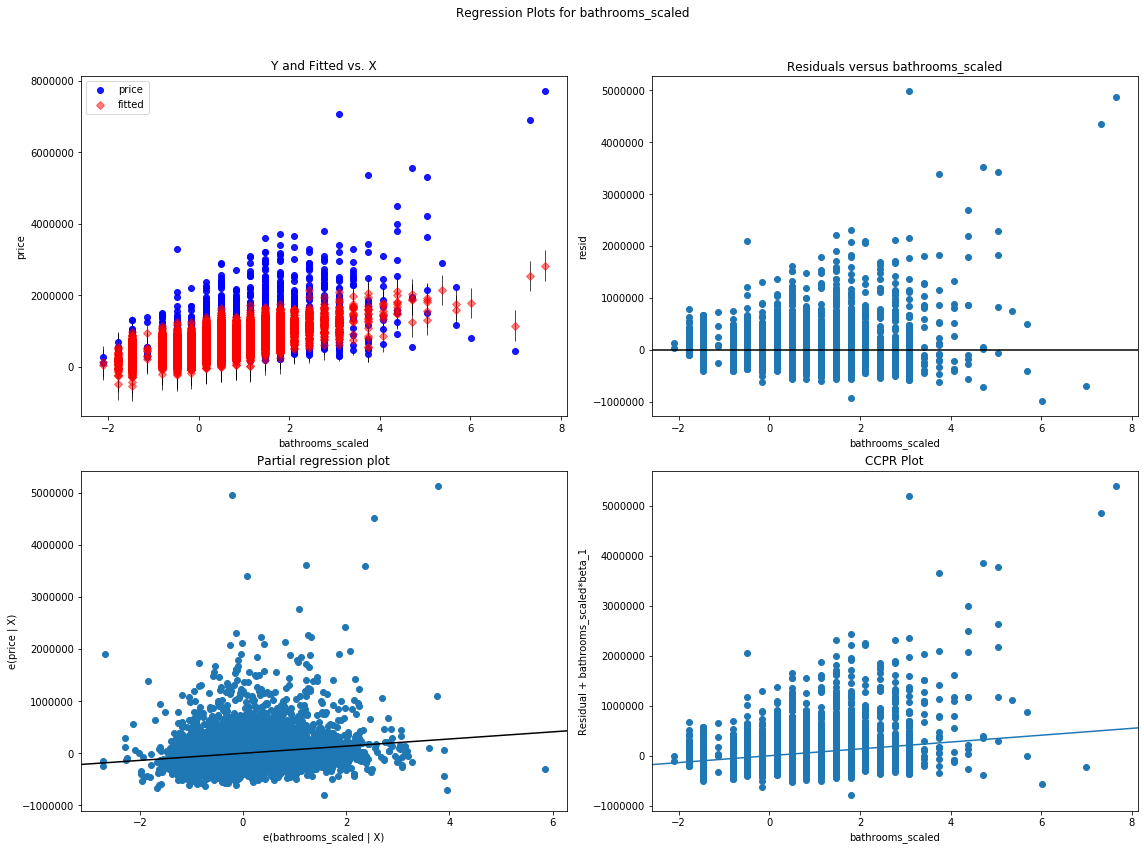

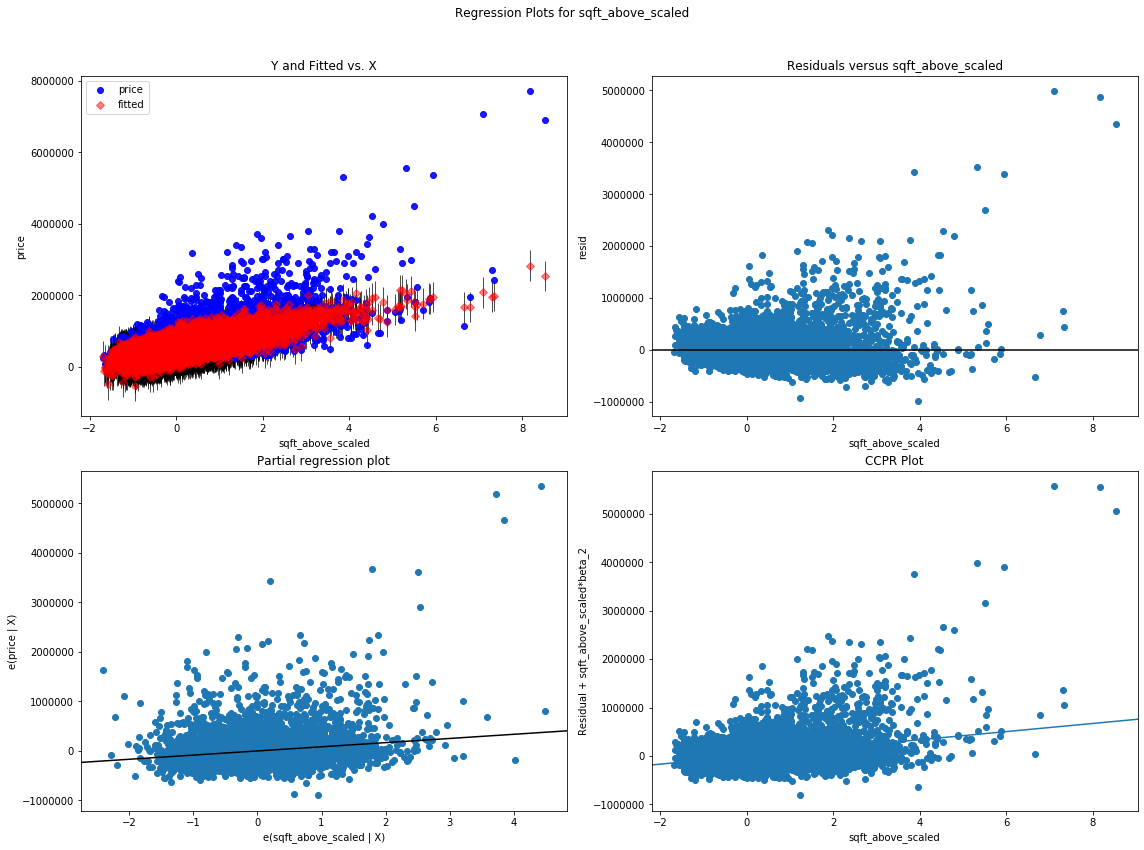

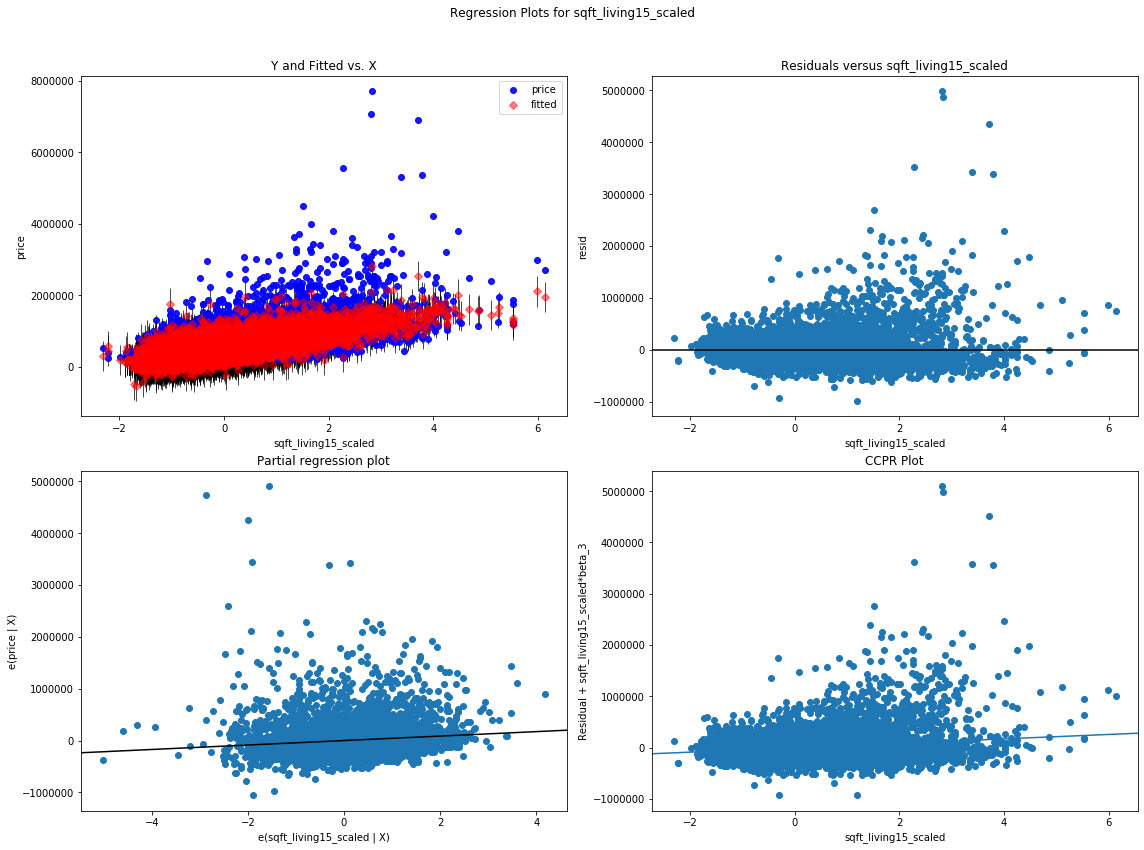

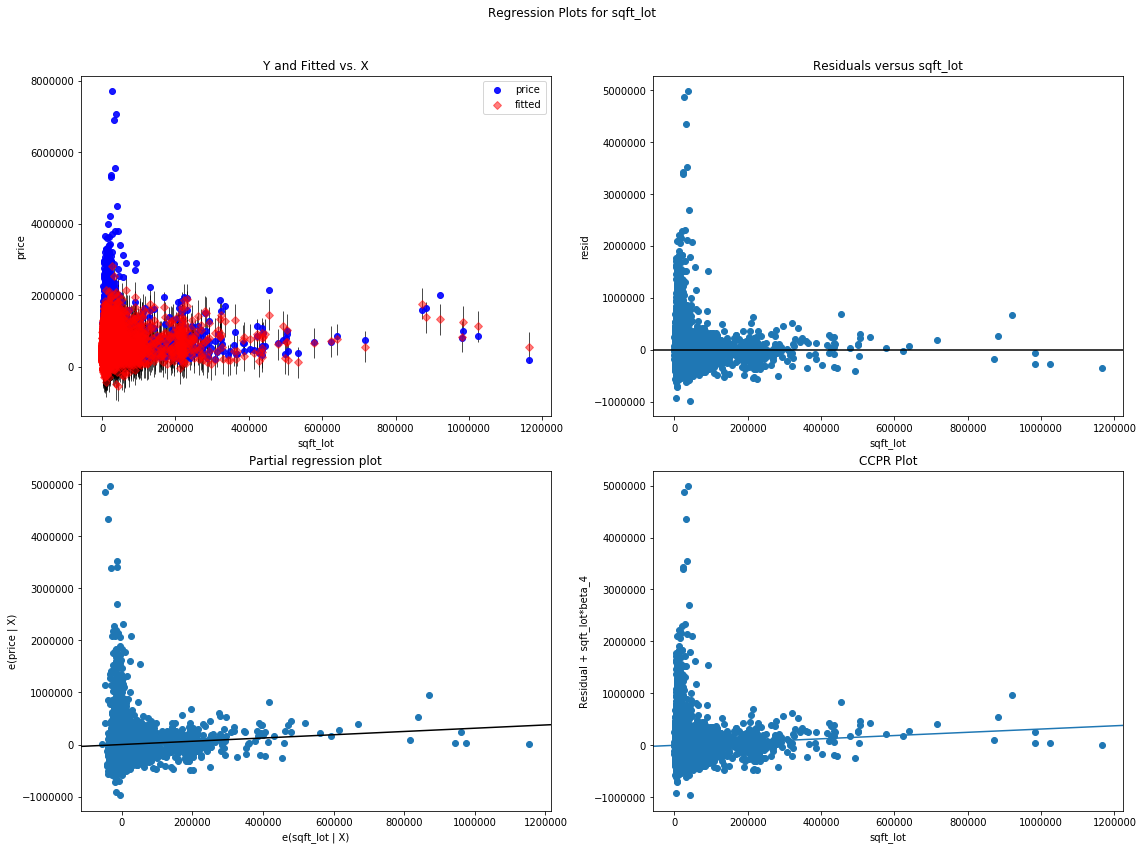

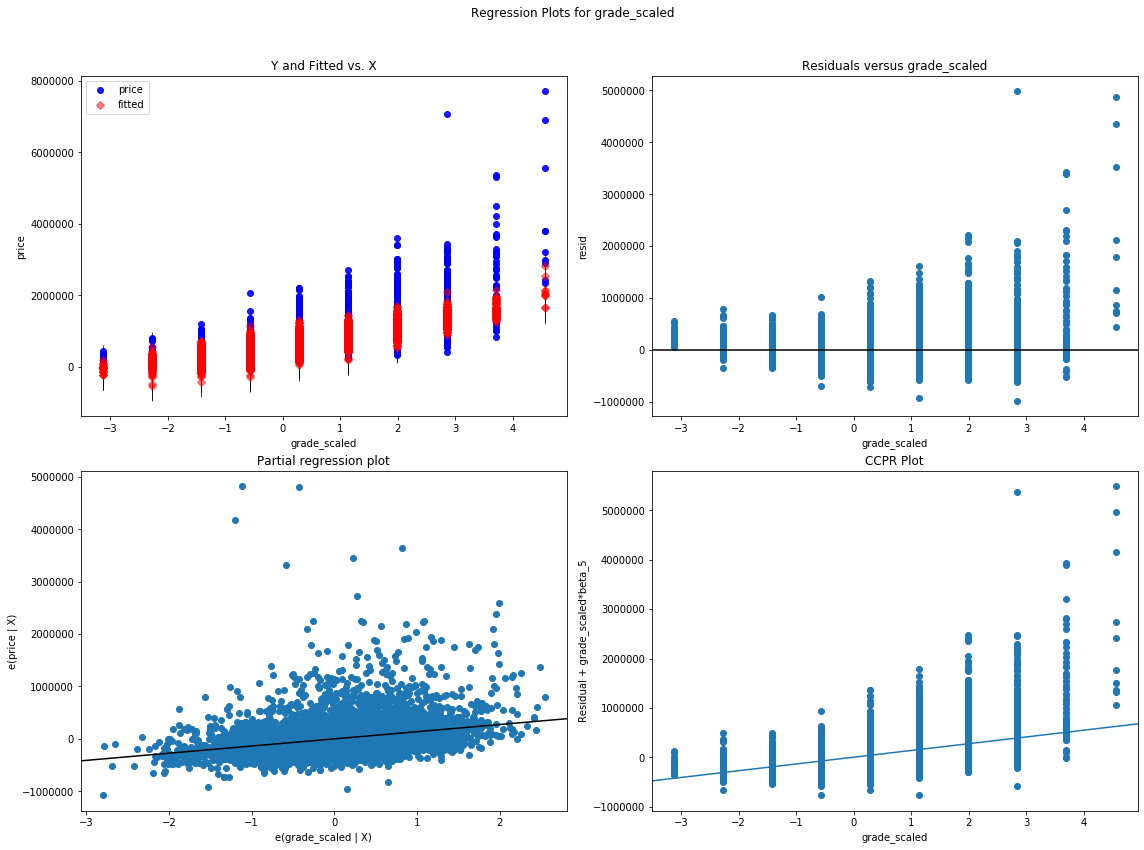

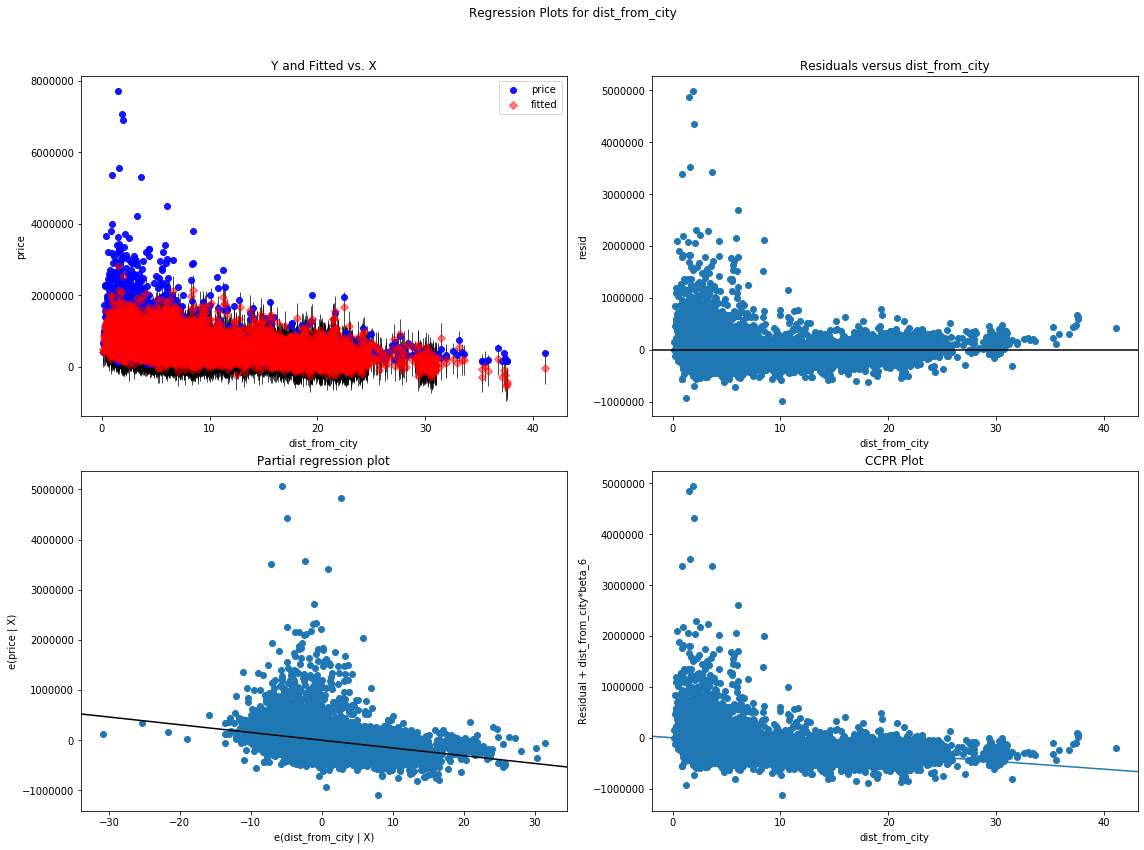

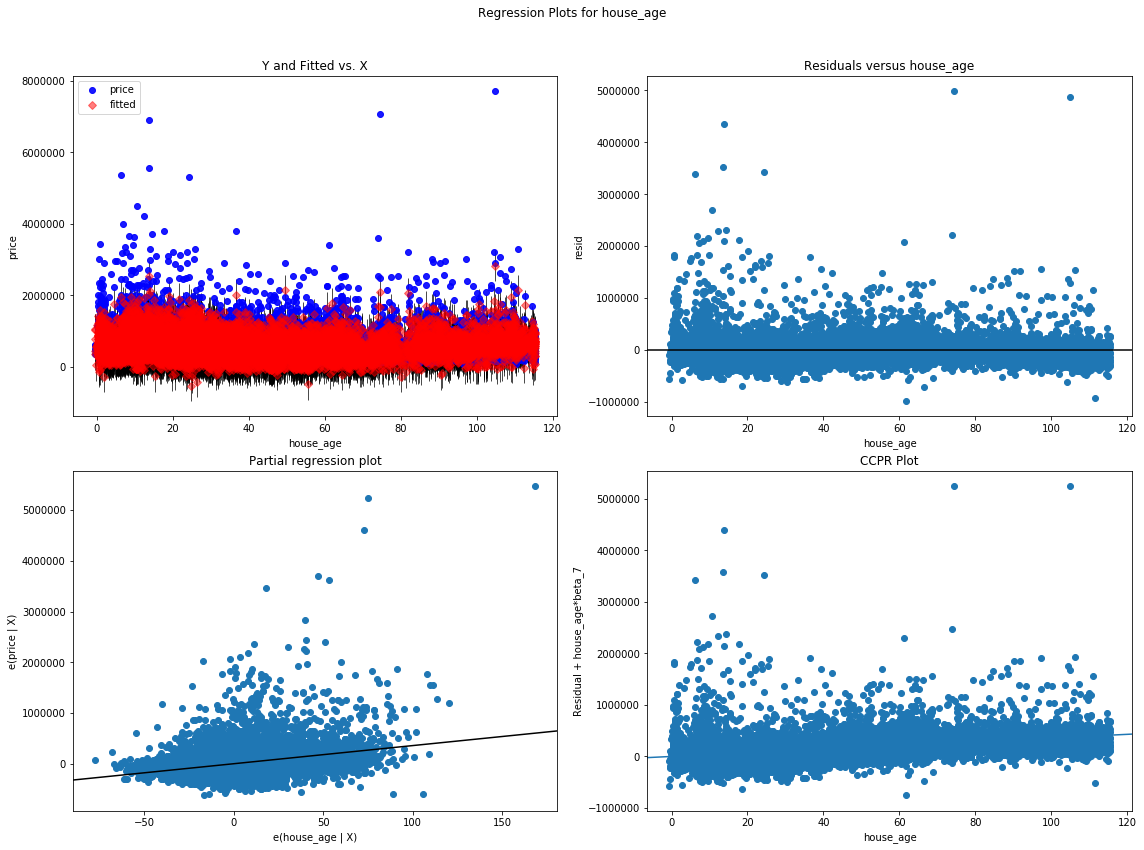

In [81]:
regression_plots(X_train_cont_features_rerun, model_cont_features)

### Summary

Removing the largest outlier in sqft_living improved the correlation of sqft_living to the target, but only had marginal improvement to the model.

The standardizations reduced the multicolinearity of the model, but not all of it.  Multiple features were removed to make the interpretation of the remaining features better, but the model's performance stats, R^2 and RMSE got worse.  Despite the worse stats, the coefficients should be more trustworthy.

## Add Features based upon findings of Simple Model

### Add Categorical Feature for Houses over 3 million dollars

In [82]:
# df_clean['mansion'] = 0

In [83]:
# mask = y_train[y_train >= 3000000].index

In [84]:
# df_clean.loc[mask, 'mansion'] = 1

In [85]:
# df_clean = make_category(df_clean, 'mansion')

### Flag for urban

5 miles or less from a city center

In [86]:
def is_urban(distance):
    """return if the distance is 5 or less from the center of a city"""
    if distance >=5:
        return 0
    else:
        return 1
        
X_train['urban'] = X_train.dist_from_city.apply(is_urban)

In [87]:
X_test['urban'] = X_test.dist_from_city.apply(is_urban)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
X_train = make_category(X_train, 'urban')
X_test = make_category(X_test, 'urban')

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Simple Model + Categoricals

This model will contain all the continuous variables and the categorical variables.  The continuous variables that were removed above will be put back into the feature list for the initial run of this model.

### Define Feature Sets

Because there are no so many features, I will specify which to ignore instead of which to include.

In [89]:
for col in X_train.columns:
    print(col)

id
date
bedrooms
bathrooms
sqft_living
sqft_lot
floors
grade
sqft_above
sqft_basement
yr_built
yr_renovated
lat
long
sqft_living15
sqft_lot15
dist_from_city
house_age
view__1
view__2
view__3
view__4
waterfront__1
had_reno__1
yr_updated_(1954.0, 1977.0]
yr_updated_(1977.0, 1999.0]
yr_updated_(1999.0, 2015.0]
condition_2
condition_3
condition_4
condition_5
_98002
_98003
_98004
_98005
_98006
_98007
_98008
_98010
_98011
_98014
_98019
_98022
_98023
_98024
_98027
_98028
_98029
_98030
_98031
_98032
_98033
_98034
_98038
_98039
_98040
_98042
_98045
_98052
_98053
_98055
_98056
_98058
_98059
_98065
_98070
_98072
_98074
_98075
_98077
_98092
_98102
_98103
_98105
_98106
_98107
_98108
_98109
_98112
_98115
_98116
_98117
_98118
_98119
_98122
_98125
_98126
_98133
_98136
_98144
_98146
_98148
_98155
_98166
_98168
_98177
_98178
_98188
_98198
_98199
season__1
season__2
new_build__1
split_level__1
has_basement__1
bathrooms_scaled
sqft_above_scaled
sqft_living15_scaled
grade_scaled
floors_scaled
bedrooms_scal

In [90]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
ssc_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
ssc_cols = sorted(ssc_cols)

X_train_ssc_features = X_train[ssc_cols]
X_test_ssc_features = X_test[ssc_cols]

### Linear Regression sklearn

In [91]:
lin_reg_sklearn(X_train_ssc_features, X_test_ssc_features, y_train, y_test)

Training Set RMSE: 162906.63802490736
Test Set RMSE: 162582.4032820635
Cross Val RMSE: 165084.03917191093


### Linear Regression Statsmodels

In [92]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     706.7
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:29:15   Log-Likelihood:            -2.2992e+05
No. Observations:               17133   AIC:                         4.600e+05
Df Residuals:                   17034   BIC:                         4.608e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        3.923e+05   4.47e+04      8.768      0.000    3.05e+05     4.8e+05
_98002                       2.462e+04   1.62e+04      1.523      0.128   -7058.163    5.63e+04
_98003                       -1.57e+04   1.47e+04     -1.070      0.285   -4.45e+04    1.31e+04
_98004                       6.245e+05   2.36e+04     26.509      0.000    5.78e+05    6.71e+05
_98005                        1.35e+05   2.46e+04      5.479      0.000    8.67e+04    1.83e+05
_98006                       1.432e+05      2e+04      7.148      0.000    1.04e+05    1.82e+05
_98007                        9.93e+04   2.54e+04      3.905      0.000    4.95e+04    1.49e+05
_98008                       1.022e+05    2.2e+04      4.647      0.000    5.91e+04    1.45e+05
_98010                        6.67e+04   2.11e+04      3.163      0.002    2.54e+04    1.08e+05
_98011                      -8676.3554   2.23e+04     -0.389      0.697   -5.24e+04     3.5e+04
_98014                       4.076e+04    2.1e+04      1.940      0.052    -413.409    8.19e+04
_98019                      -1.202e+04   2.05e+04     -0.587      0.557   -5.21e+04    2.81e+04
_98022                       4.241e+04   1.78e+04      2.387      0.017    7588.126    7.72e+04
_98023                      -2.399e+04   1.27e+04     -1.887      0.059   -4.89e+04     930.982
_98024                        8.85e+04   2.53e+04      3.500      0.000    3.89e+04    1.38e+05
_98027                       8.444e+04   1.73e+04      4.884      0.000    5.06e+04    1.18e+05
_98028                      -6618.1659   2.07e+04     -0.319      0.750   -4.73e+04     3.4e+04
_98029                       1.191e+05   1.82e+04      6.527      0.000    8.33e+04    1.55e+05
_98030                      -2.939e+04   1.52e+04     -1.934      0.053   -5.92e+04     391.781
_98031                      -3.455e+04    1.6e+04     -2.153      0.031    -6.6e+04   -3095.579
_98032                      -1.927e+04   1.95e+04     -0.990      0.322   -5.74e+04    1.89e+04
_98033                       1.908e+05   2.28e+04      8.383      0.000    1.46e+05    2.35e+05
_98034                       5.366e+04    2.1e+04      2.556      0.011    1.25e+04    9.48e+04
_98038                       1.089e+04   1.25e+04      0.872      0.383   -1.36e+04    3.54e+04
_98039                       1.258e+06   3.36e+04     37.413      0.000    1.19e+06    1.32e+06
_98040                       3.713e+05   2.19e+04     16.950      0.000    3.28e+05    4.14e+05
_98042                      -2.328e+04   1.28e+04     -1.813      0.070   -4.85e+04    1887.494
_98045                       9.433e+04   1.58e+04      5.961      0.000    6.33e+04    1.25e+05
_98052                       6.391e+04    2.2e+04      2.911      0.004    2.09e+04    1.07e+05
_98053     

### Check for Multicolinearity

In [93]:
vif_analysis(X_train_ssc_features)

Variance inflation factor for _98002: 1.54
Variance inflation factor for _98003: 1.73
Variance inflation factor for _98004: 4.06
Variance inflation factor for _98005: 2.6
Variance inflation factor for _98006: 4.75
Variance inflation factor for _98007: 2.14
Variance inflation factor for _98008: 3.34
Variance inflation factor for _98010: 1.27
Variance inflation factor for _98011: 2.29
Variance inflation factor for _98014: 1.5
Variance inflation factor for _98019: 2.01
Variance inflation factor for _98022: 2.18
Variance inflation factor for _98023: 2.32
Variance inflation factor for _98024: 1.29
Variance inflation factor for _98027: 2.93
Variance inflation factor for _98028: 2.94
Variance inflation factor for _98029: 2.56
Variance inflation factor for _98030: 1.76
Variance inflation factor for _98031: 1.87
Variance inflation factor for _98032: 1.37
Variance inflation factor for _98033: 5.16
Variance inflation factor for _98034: 5.61
Variance inflation factor for _98038: 2.58
Variance infl

### Analyze the Residuals

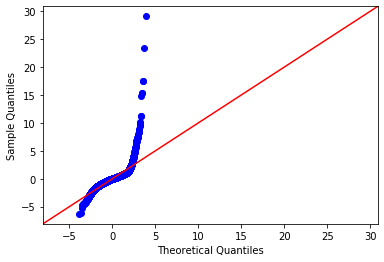

In [94]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

The yr_updated features don't make sense, a base value of the oldest houses shouldn't be the most expensive house, so they also will be removed.

In [95]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 'yr_updated_(1954.0, 1977.0]',
         'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]', 'dist_from_city']

X_train_cols = [col for col in X_train_ssc_features.columns if col not in m_cols]

In [96]:
BidirectionalStepwiseSelection(X_train_ssc_features[X_train_cols], y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : view__4 	AIC : 486111.7482540093
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 478314.3364213098
break : No need to Backward Elimination
Entered : grade_scaled 	AIC : 475510.86908040394
break : No need to Backward Elimination
Entered : _98004 	AIC : 473958.7386006508
break : No need to Backward Elimination
Entered : urban__1 	AIC : 470881.15866061265
break : No need to Backward Elimination
Entered : house_age 	AIC : 468724.2788350913
break : No need to Backward Elimination
Entered : _98039 	AIC : 467561.6318860412
break : No need to Backward Elimination
Entered : has_basement__1 	AIC : 466463.38883140456
break : No need to Backward Elimination
Entered : waterfront__1 	AIC : 465881.6391977091
break : No need to Backward Elimination
Entered : _98040 	AIC : 465367.0309309499
break : No need to Backward Elimination
Entered : _98112 	AIC : 465019.

(['intercept',
  'view__4',
  'sqft_above_scaled',
  'grade_scaled',
  '_98004',
  'urban__1',
  'house_age',
  '_98039',
  'has_basement__1',
  'waterfront__1',
  '_98040',
  '_98112',
  'view__3',
  '_98117',
  '_98023',
  'bathrooms_scaled',
  '_98033',
  '_98103',
  'view__2',
  '_98105',
  '_98092',
  '_98115',
  '_98006',
  '_98119',
  '_98199',
  '_98102',
  '_98109',
  'condition_5',
  '_98042',
  '_98003',
  '_98107',
  'view__1',
  '_98029',
  '_98177',
  '_98198',
  '_98030',
  '_98058',
  '_98022',
  '_98038',
  '_98031',
  'sqft_lot',
  'sqft_living15_scaled',
  '_98122',
  '_98070',
  'condition_4',
  '_98136',
  '_98032',
  '_98002',
  '_98178',
  'season__1',
  '_98005',
  '_98116',
  '_98144',
  '_98125',
  '_98053',
  '_98008',
  '_98052',
  '_98133',
  '_98027',
  '_98126',
  '_98034',
  '_98007',
  '_98118',
  '_98075',
  '_98155',
  '_98074',
  '_98072',
  '_98106',
  'had_reno__1',
  'new_build__1',
  'split_level__1',
  '_98024',
  '_98077',
  '_98028',
  '_98056

### Summary

The R^2 and RMSE stats saw a significant improvement over the baseline model.

Some of the features that were dropped from the baseline model were found to be significant here.

There still seemed to be some multicolinearity issues with floors_scaled and bedrooms_scaled.

There were quite a few of the categorical features that had high p-values.  A stepwise selection was run to find out a potentially better feature set.

## Rerun the Simple + Categoricals Model

The simple + categoricals model will be rerun with the feature set chosen by stepwise selection.

### Define Features

In [97]:
# columns chosen by stepwise selection
cols_to_include = ['view__4', 'sqft_above_scaled', 'grade_scaled', '_98004', 'urban__1', 'house_age', '_98039', 'has_basement__1', 'waterfront__1', '_98040', '_98112', 'view__3', '_98117', '_98023', 'bathrooms_scaled', '_98033', '_98103', 'view__2', '_98105', '_98092', '_98115', '_98006', '_98119', '_98199', '_98102', '_98109', 'condition_5', '_98042', '_98003', '_98107', 'view__1', '_98029', '_98177', '_98198', '_98030', '_98058', '_98022', '_98038', '_98031', 'sqft_lot', 'sqft_living15_scaled', '_98122', '_98070', 'condition_4', '_98136', '_98032', '_98002', '_98178', 'season__1', '_98005', '_98116', '_98144', '_98125', '_98053', '_98008', '_98052', '_98133', '_98027', '_98126', '_98034', '_98007', '_98118', '_98075', '_98155', '_98074', '_98072', '_98106', 'had_reno__1', 'new_build__1', 'split_level__1', '_98024', '_98077', '_98028', '_98056']

In [98]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [99]:
X_train_ssc_features_rerun = X_train[cols_to_include]
X_test_ssc_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [100]:
lin_reg_sklearn(X_train_ssc_features_rerun, X_test_ssc_features_rerun, y_train, y_test)

Training Set RMSE: 165674.63057292835
Test Set RMSE: 167299.02691236464
Cross Val RMSE: 167625.2777728792


### Linear Regression Statsmodels

In [101]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     898.6
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:39:01   Log-Likelihood:            -2.3021e+05
No. Observations:               17133   AIC:                         4.606e+05
Df Residuals:                   17058   BIC:                         4.612e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.843e+05   6747.761     42.131      0.000    2.71e+05    2.98e+05
_98002               -4.602e+04   1.36e+04     -3.384      0.001   -7.27e+04   -1.94e+04
_98003               -8.441e+04   1.17e+04     -7.225      0.000   -1.07e+05   -6.15e+04
_98004                7.016e+05   1.21e+04     58.118      0.000    6.78e+05    7.25e+05
_98005                1.925e+05   1.53e+04     12.615      0.000    1.63e+05    2.22e+05
_98006                1.842e+05   9485.008     19.421      0.000    1.66e+05    2.03e+05
_98007                1.403e+05   1.72e+04      8.135      0.000    1.07e+05    1.74e+05
_98008                1.438e+05   1.24e+04     11.643      0.000     1.2e+05    1.68e+05
_98022               -9.165e+04   1.28e+04     -7.184      0.000   -1.17e+05   -6.66e+04
_98023                -9.69e+04   9013.684    -10.751      0.000   -1.15e+05   -7.92e+04
_98024                7.998e+04   2.24e+04      3.569      0.000    3.61e+04    1.24e+05
_98027                9.519e+04   9940.980      9.575      0.000    7.57e+04    1.15e+05
_98028                3.411e+04   1.16e+04      2.949      0.003    1.14e+04    5.68e+04
_98029                1.295e+05   1.12e+04     11.614      0.000    1.08e+05    1.51e+05
_98030               -7.005e+04   1.17e+04     -5.979      0.000    -9.3e+04   -4.71e+04
_98031               -6.121e+04   1.18e+04     -5.194      0.000   -8.43e+04   -3.81e+04
_98032               -6.316e+04   1.69e+04     -3.741      0.000   -9.63e+04   -3.01e+04
_98033                2.589e+05   1.06e+04     24.482      0.000    2.38e+05     2.8e+05
_98034                1.038e+05   9666.319     10.741      0.000    8.49e+04    1.23e+05
_98038               -4.102e+04   8385.009     -4.892      0.000   -5.75e+04   -2.46e+04
_98039                1.348e+06   2.74e+04     49.132      0.000    1.29e+06     1.4e+06
_98040                4.158e+05   1.23e+04     33.884      0.000    3.92e+05     4.4e+05
_98042               -6.839e+04   8651.063     -7.905      0.000   -8.53e+04   -5.14e+04
_98052                1.236e+05   9682.115     12.761      0.000    1.05e+05    1.43e+05
_98053                1.179e+05   1.02e+04     11.530      0.000    9.79e+04    1.38e+05
_98056                2.901e+04   9783.486      2.965      0.003    9834.623    4.82e+04
_98058               -4.573e+04   9135.605     -5.006      0.000   -6.36e+04   -2.78e+04
_98070               -9.519e+04   1.84e+04     -5.183      0.000   -1.31e+05   -5.92e+04
_98072                7.436e+04   1.17e+04      6.349      0.000    5.14e+04    9.73e+04
_98074                7.873e+04   9957.940      7.907      0.000    5.92e+04    9.83e+04
_98075                 8.46e+04   1.07e+04      7.903      0.000    6.36e+04    1.06e+05
_98077                4.051e+04   1.37e+04      2.954    

### Check for Multicolinearity

In [102]:
vif_analysis(X_train_ssc_features_rerun)

Variance inflation factor for _98002: 1.06
Variance inflation factor for _98003: 1.07
Variance inflation factor for _98004: 1.31
Variance inflation factor for _98005: 1.17
Variance inflation factor for _98006: 1.3
Variance inflation factor for _98007: 1.12
Variance inflation factor for _98008: 1.25
Variance inflation factor for _98022: 1.08
Variance inflation factor for _98023: 1.12
Variance inflation factor for _98024: 1.04
Variance inflation factor for _98027: 1.11
Variance inflation factor for _98028: 1.09
Variance inflation factor for _98029: 1.09
Variance inflation factor for _98030: 1.06
Variance inflation factor for _98031: 1.07
Variance inflation factor for _98032: 1.03
Variance inflation factor for _98033: 1.37
Variance inflation factor for _98034: 1.45
Variance inflation factor for _98038: 1.14
Variance inflation factor for _98039: 1.07
Variance inflation factor for _98040: 1.22
Variance inflation factor for _98042: 1.14
Variance inflation factor for _98052: 1.48
Variance inf

### Analyze the Residuals

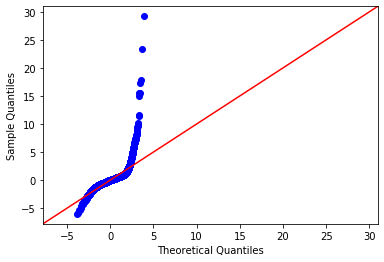

In [103]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Summary

The re-run of the simple plus categoricals model did not change the R^2 and RMSE much, they in fact got a little worse, which is often the case when features are dropped, even if they are not significant.

However, the re-run with its feature set is the best model so far.

## Add Interaction Features

### sq_lot / sq_lot15

The size of the house lot as compared to its neighbors

In [104]:
X_train['lot*lot15'] = X_train.sqft_lot * X_train.sqft_lot15
X_test['lot*lot15'] = X_test.sqft_lot * X_test.sqft_lot15

### bathroom* bedroom

Home buyers often want enough bathrooms for the bedrooms in a house.

In [105]:
X_train['bathrooms_scaled*bedrooms_scaled'] = X_train.bathrooms_scaled * X_train.bedrooms_scaled
X_test['bathrooms_scaled*bedrooms_scaled'] = X_test.bathrooms_scaled * X_test.bedrooms_scaled

### sqft_above * floors

How the living space is split up among the floors

In [106]:
X_train['sqft_above_scaled*floors_scaled'] = X_train.sqft_above_scaled * X_train.floors_scaled
X_test['sqft_above_scaled*floors_scaled'] = X_test.sqft_above_scaled * X_test.floors_scaled

### sqft_living * sqft_living15

How the living space compares to its neighbors

In [107]:
X_train['sqft_above_scaled*sqft_living15_scaled'] = X_train.sqft_above_scaled * X_train.sqft_living15_scaled
X_test['sqft_above_scaled*sqft_living15_scaled'] = X_test.sqft_above_scaled * X_test.sqft_living15_scaled

### sqft_above * sqft_lot

How the house fits on the property

In [108]:
X_train['sqft_above_scaled*sqft_lot'] = X_train.sqft_above_scaled * X_train.sqft_lot
X_test['sqft_above_scaled*sqft_lot'] = X_test.sqft_above_scaled * X_test.sqft_lot

### bedrooms * grade

In [109]:
X_train['bedrooms*grade'] = X_train.bedrooms * X_train.grade
X_test['bedrooms*grade'] = X_test.bedrooms * X_test.grade

### sqft_above * grade

In [110]:
X_train['sqft_above_scaled*grade'] = X_train.sqft_above_scaled * X_train.grade
X_test['sqft_above_scaled*grade'] = X_test.sqft_above_scaled * X_test.grade

### sqft_above * bedrooms

How big are the bedrooms?

In [111]:
X_train['sqft_above_scaled*bedrooms_scaled'] = X_train.sqft_above_scaled * X_train.bedrooms_scaled
X_test['sqft_above_scaled*bedrooms_scaled'] = X_test.sqft_above_scaled * X_test.bedrooms_scaled

### season_1*waterfront_1

In [112]:
X_train['season__1*waterfront__1'] = X_train.season__1 * X_train.waterfront__1
X_test['season__1*waterfront__1'] = X_test.season__1 * X_test.waterfront__1

### dist_from_city*waterfront_1

In [113]:
X_train['dist_from_city*waterfront__1'] = X_train.dist_from_city * X_train.waterfront__1
X_test['dist_from_city*waterfront__1'] = X_test.dist_from_city * X_test.waterfront__1

### floors*split_level__1

In [114]:
X_train['floors_scaled*split_level__1'] = X_train.floors_scaled * X_train.split_level__1
X_test['floors_scaled*split_level__1'] = X_test.floors_scaled * X_test.split_level__1

### had_reno*year_updated Bins

In [115]:
year_bins = ['yr_updated_(1977.0, 1999.0]', 'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1999.0, 2015.0]']
for year in year_bins:
    col_name = 'had_reno*'+year
    X_train[col_name] = X_train.had_reno__1 * X_train[year]
    X_test[col_name] = X_test.had_reno__1 * X_test[year]

### is_urban*dist_from_city

In [116]:
# X_train['urban*dist_from_city'] = X_train.urban * X_train.dist_from_city
# X_test['urban*dist_from_city'] = X_test.urban * X_test.dist_from_city

## Model With Interactions

This model will run with all the continuous and categorical features, plus the new interaction features.

### Define Feature Sets

In [117]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
int_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
int_cols = sorted(int_cols)

X_train_int_features = X_train[int_cols]
X_test_int_features = X_test[int_cols]

### Linear Regression sklearn

In [118]:
lin_reg_sklearn(X_train_int_features, X_test_int_features, y_train, y_test)

Training Set RMSE: 147788.45729393864
Test Set RMSE: 145792.52458813303
Cross Val RMSE: 150741.0545844499


### Linear Regression statsmodels

In [119]:
model_int_features = lin_reg_statsmodels(X_train_int_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     783.5
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        13:53:47   Log-Likelihood:            -2.2825e+05
No. Observations:               17133   AIC:                         4.567e+05
Df Residuals:                   17020   BIC:                         4.576e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   9.711e+04   5.88e+04      1.651      0.099   -1.82e+04    2.12e+05
_98002                                  7700.1635   1.47e+04      0.525      0.600   -2.11e+04    3.65e+04
_98003                                 -1.704e+04   1.33e+04     -1.279      0.201   -4.32e+04    9078.054
_98004                                  6.058e+05   2.15e+04     28.237      0.000    5.64e+05    6.48e+05
_98005                                  1.514e+05   2.24e+04      6.755      0.000    1.07e+05    1.95e+05
_98006                                  1.349e+05   1.82e+04      7.399      0.000    9.91e+04    1.71e+05
_98007                                  1.047e+05   2.31e+04      4.531      0.000    5.94e+04     1.5e+05
_98008                                  1.036e+05      2e+04      5.182      0.000    6.44e+04    1.43e+05
_98010                                    5.1e+04   1.92e+04      2.661      0.008    1.34e+04    8.86e+04
_98011                                  1.308e+04   2.03e+04      0.646      0.519   -2.66e+04    5.28e+04
_98014                                  2.871e+04   1.91e+04      1.504      0.133   -8710.331    6.61e+04
_98019                                  9005.7746   1.86e+04      0.484      0.628   -2.75e+04    4.55e+04
_98022                                  3.472e+04   1.62e+04      2.150      0.032    3068.096    6.64e+04
_98023                                 -2.573e+04   1.15e+04     -2.229      0.026   -4.84e+04   -3105.654
_98024                                  1.014e+05    2.3e+04      4.401      0.000    5.63e+04    1.47e+05
_98027                                  8.337e+04   1.57e+04      5.301      0.000    5.25e+04    1.14e+05
_98028                                  1.427e+04   1.88e+04      0.757      0.449   -2.27e+04    5.12e+04
_98029                                  1.324e+05   1.66e+04      7.988      0.000    9.99e+04    1.65e+05
_98030                                 -2.223e+04   1.38e+04     -1.611      0.107   -4.93e+04    4812.300
_98031                                 -3.173e+04   1.46e+04     -2.177      0.029   -6.03e+04   -3162.959
_98032                                 -2.772e+04   1.77e+04     -1.568      0.117   -6.24e+04    6932.372
_98033                                  1.932e+05   2.07e+04      9.336      0.000    1.53e+05    2.34e+05
_98034                                  5.067e+04   1.91e+04      2.656      0.008    1.33e+04    8.81e+04
_98038                                  1.951e+04   1.13e+04      1.721      0.085   -2706.528    4.17e+04
_98039                                   1.13e+06   3.08e+04     36.731      0.000    1.07e+06    1.19e+06
_98040                                  3.518e+05   1.99e+04     17.647      0.000    3

### Check for Multicolinearity

In [120]:
vif_analysis(X_train_int_features)

Variance inflation factor for _98002: 1.54
Variance inflation factor for _98003: 1.73
Variance inflation factor for _98004: 4.63
Variance inflation factor for _98005: 2.91
Variance inflation factor for _98006: 5.39
Variance inflation factor for _98007: 2.33
Variance inflation factor for _98008: 3.7
Variance inflation factor for _98010: 1.28
Variance inflation factor for _98011: 2.54
Variance inflation factor for _98014: 1.57
Variance inflation factor for _98019: 2.19
Variance inflation factor for _98022: 2.18
Variance inflation factor for _98023: 2.3
Variance inflation factor for _98024: 1.34
Variance inflation factor for _98027: 3.23
Variance inflation factor for _98028: 3.28
Variance inflation factor for _98029: 2.8
Variance inflation factor for _98030: 1.8
Variance inflation factor for _98031: 1.96
Variance inflation factor for _98032: 1.39
Variance inflation factor for _98033: 5.84
Variance inflation factor for _98034: 6.29
Variance inflation factor for _98038: 2.61
Variance inflat

### Analyze the Residuals

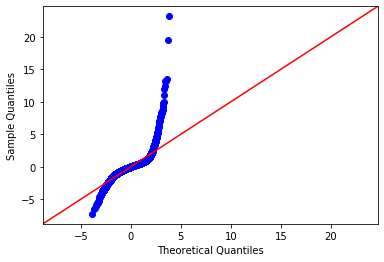

In [121]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

### Stepwise Selection

In [137]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 
          'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]',
         'had_reno*yr_updated_(1954.0, 1977.0]', 'had_reno*yr_updated_(1977.0, 1999.0]', 'had_reno*yr_updated_(1999.0, 2015.0]',
         'sqft_above_scaled*sqft_living15_scaled', 'sqft_above_scaled*bedrooms_scaled', 
          'sqft_above_scaled*floors_scaled', 'sqft_above_scaled*grade', 'sqft_above_scaled*sqft_lot',
         'bedrooms*grade']

X_train_cols = [col for col in X_train_int_features.columns if col not in m_cols]

In [138]:
BidirectionalStepwiseSelection(X_train_int_features[X_train_cols], y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : grade_scaled 	AIC : 477627.34669450246
break : No need to Backward Elimination
Entered : dist_from_city 	AIC : 474583.406198738
break : No need to Backward Elimination
Entered : waterfront__1 	AIC : 473115.26222283975
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 471220.8450225329
break : No need to Backward Elimination
Entered : house_age 	AIC : 469405.8314863081
break : No need to Backward Elimination
Entered : _98004 	AIC : 468070.31658168667
break : No need to Backward Elimination
Entered : _98039 	AIC : 466824.675441236
break : No need to Backward Elimination
Entered : has_basement__1 	AIC : 465662.37836593826
break : No need to Backward Elimination
Entered : view__4 	AIC : 465098.06285776536
break : No need to Backward Elimination
Entered : _98040 	AIC : 464560.334845191
break : No need to Backward Elimination
Entered : bathrooms_scaled

(['intercept',
  'grade_scaled',
  'dist_from_city',
  'waterfront__1',
  'sqft_above_scaled',
  'house_age',
  '_98004',
  '_98039',
  'has_basement__1',
  'view__4',
  '_98040',
  'bathrooms_scaled*bedrooms_scaled',
  '_98112',
  'dist_from_city*waterfront__1',
  'view__3',
  'urban__1',
  'condition_5',
  '_98117',
  'view__2',
  '_98105',
  '_98103',
  '_98102',
  '_98119',
  '_98033',
  '_98199',
  '_98115',
  '_98109',
  'sqft_lot',
  '_98006',
  '_98107',
  'floors_scaled*split_level__1',
  'bathrooms_scaled',
  'view__1',
  '_98029',
  '_98177',
  '_98122',
  '_98027',
  'bedrooms*grade',
  'condition_4',
  '_98045',
  '_98178',
  '_98116',
  '_98058',
  'season__1',
  'had_reno__1',
  'sqft_living15_scaled',
  '_98136',
  '_98144',
  '_98005',
  '_98133',
  '_98125',
  '_98022',
  '_98008',
  '_98010',
  '_98065',
  '_98038',
  '_98024',
  'season__1*waterfront__1',
  '_98075',
  '_98053',
  '_98126',
  '_98002',
  'new_build__1',
  '_98007',
  '_98052',
  '_98118',
  '_98034'

## Re-Run Model with Interactions

### Define Features

In [139]:
# columns chosen by stepwise selection
cols_to_include = ['grade_scaled', 'dist_from_city', 'waterfront__1', 'sqft_above_scaled', 'house_age', '_98004', '_98039', 'has_basement__1', 'view__4', '_98040', 'bathrooms_scaled*bedrooms_scaled', '_98112', 'dist_from_city*waterfront__1', 'view__3', 'urban__1', 'condition_5', '_98117', 'view__2', '_98105', '_98103', '_98102', '_98119', '_98033', '_98199', '_98115', '_98109', 'sqft_lot', '_98006', '_98107', 'floors_scaled*split_level__1', 'bathrooms_scaled', 'view__1', '_98029', '_98177', '_98122', '_98027', 'bedrooms*grade', 'condition_4', '_98045', '_98178', '_98116', '_98058', 'season__1', 'had_reno__1', 'sqft_living15_scaled', '_98136', '_98144', '_98005', '_98133', '_98125', '_98022', '_98008', '_98010', '_98065', '_98038', '_98024', 'season__1*waterfront__1', '_98075', '_98053', '_98126', '_98002', 'new_build__1', '_98007', '_98052', '_98118', '_98034', '_98155', '_98074', '_98072', '_98014', '_98070', 'split_level__1', '_98106']
# columns to add back because of interactions that are significant
cols_to_add = []
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [140]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [141]:
X_train_int_features_rerun = X_train[cols_to_include]
X_test_int_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [142]:
lin_reg_sklearn(X_train_int_features_rerun, X_test_int_features_rerun, y_train, y_test)

Training Set RMSE: 158751.54217857233
Test Set RMSE: 154163.6985211754
Cross Val RMSE: 161112.17566900185


### Linear Regression statsmodels

In [143]:
model_int_features = lin_reg_statsmodels(X_train_int_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1013.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        14:36:18   Log-Likelihood:            -2.2948e+05
No. Observations:               17133   AIC:                         4.591e+05
Df Residuals:                   17059   BIC:                         4.597e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             4.515e+05   1.03e+04     43.635      0.000    4.31e+05    4.72e+05
_98002                            4.538e+04   1.32e+04      3.446      0.001    1.96e+04    7.12e+04
_98004                             6.34e+05   1.18e+04     53.684      0.000    6.11e+05    6.57e+05
_98005                            1.422e+05   1.48e+04      9.639      0.000    1.13e+05    1.71e+05
_98006                            1.475e+05   9142.842     16.137      0.000     1.3e+05    1.65e+05
_98007                            1.015e+05   1.66e+04      6.113      0.000     6.9e+04    1.34e+05
_98008                            1.015e+05   1.19e+04      8.521      0.000    7.82e+04    1.25e+05
_98010                            8.807e+04   1.86e+04      4.730      0.000    5.16e+04    1.25e+05
_98014                            5.585e+04   1.65e+04      3.387      0.001    2.35e+04    8.82e+04
_98022                            6.827e+04   1.35e+04      5.060      0.000    4.18e+04    9.47e+04
_98024                            1.079e+05   2.14e+04      5.038      0.000    6.59e+04     1.5e+05
_98027                            9.932e+04   9375.766     10.593      0.000    8.09e+04    1.18e+05
_98029                            1.394e+05   1.06e+04     13.166      0.000    1.19e+05     1.6e+05
_98033                            1.992e+05   1.04e+04     19.108      0.000    1.79e+05     2.2e+05
_98034                            5.741e+04   9402.131      6.106      0.000     3.9e+04    7.58e+04
_98038                             3.99e+04   8028.353      4.970      0.000    2.42e+04    5.56e+04
_98039                            1.256e+06   2.64e+04     47.536      0.000     1.2e+06    1.31e+06
_98040                             3.59e+05   1.18e+04     30.334      0.000    3.36e+05    3.82e+05
_98045                            1.161e+05   1.28e+04      9.074      0.000     9.1e+04    1.41e+05
_98052                            7.002e+04   9532.946      7.345      0.000    5.13e+04    8.87e+04
_98053                              7.5e+04   9980.449      7.515      0.000    5.54e+04    9.46e+04
_98058                           -2.665e+04   8509.112     -3.131      0.002   -4.33e+04   -9966.594
_98065                            6.172e+04   1.07e+04      5.756      0.000    4.07e+04    8.27e+04
_98070                            5.956e+04   1.81e+04      3.287      0.001     2.4e+04    9.51e+04
_98072                            4.516e+04   1.13e+04      3.993      0.000     2.3e+04    6.73e+04
_98074                            4.622e+04   9641.444      4.794      0.000    2.73e+04    6.51e+04
_98075                            6.476e+04   1.02e+04      6.323      0.000    4.47e+04    8.48e+04
_98102                            3.649e+05   1.82e+0

### Summary

There are improvements to R^2 and RMSE with the addition of interating features, but the model is getting complicated.

## Model with Polynomials

This model will have all the continuous, categorical, and interacting features, plus polynomial ones

### Define Feature Sets

In [144]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
poly_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
poly_cols = sorted(poly_cols)
X_train_poly_features = X_train[poly_cols]
X_test_poly_features = X_test[poly_cols]

### Add polynomials

In [145]:
poly = PolynomialFeatures(3)
poly_grade_train = poly.fit_transform(X_train_poly_features['grade_scaled'].values.reshape(-1, 1))
poly_grade_test = poly.fit_transform(X_test_poly_features['grade_scaled'].values.reshape(-1, 1))

In [146]:
X_train_poly_features['grade^2'] = poly_grade_train[:, 2]
X_test_poly_features['grade^2'] = poly_grade_test[:, 2]
X_train_poly_features['grade^3'] = poly_grade_train[:, 3]
X_test_poly_features['grade^3'] = poly_grade_test[:, 3]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

### Linear Regression sklearn

In [147]:
lin_reg_sklearn(X_train_poly_features, X_test_poly_features, y_train, y_test)

Training Set RMSE: 145664.55072189434
Test Set RMSE: 146585.54807166397
Cross Val RMSE: 148891.92189464188


### Linear Regression statsmodels

In [148]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     796.6
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        14:37:56   Log-Likelihood:            -2.2801e+05
No. Observations:               17133   AIC:                         4.562e+05
Df Residuals:                   17018   BIC:                         4.571e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -2.229e+04   5.88e+04     -0.379      0.705   -1.38e+05     9.3e+04
_98002                                  4921.7021   1.45e+04      0.340      0.734   -2.35e+04    3.33e+04
_98003                                  -1.23e+04   1.31e+04     -0.936      0.349    -3.8e+04    1.35e+04
_98004                                   6.09e+05   2.11e+04     28.800      0.000    5.68e+05    6.51e+05
_98005                                  1.591e+05   2.21e+04      7.201      0.000    1.16e+05    2.02e+05
_98006                                  1.336e+05    1.8e+04      7.432      0.000    9.84e+04    1.69e+05
_98007                                  1.142e+05   2.28e+04      5.011      0.000    6.95e+04    1.59e+05
_98008                                  1.111e+05   1.97e+04      5.639      0.000    7.25e+04     1.5e+05
_98010                                   6.14e+04   1.89e+04      3.247      0.001    2.43e+04    9.85e+04
_98011                                   1.92e+04      2e+04      0.962      0.336   -1.99e+04    5.83e+04
_98014                                  4.078e+04   1.88e+04      2.165      0.030    3862.771    7.77e+04
_98019                                  6441.6850   1.83e+04      0.351      0.725   -2.95e+04    4.24e+04
_98022                                  3.443e+04   1.59e+04      2.162      0.031    3221.674    6.56e+04
_98023                                 -1.961e+04   1.14e+04     -1.723      0.085   -4.19e+04    2697.511
_98024                                  1.087e+05   2.27e+04      4.783      0.000    6.42e+04    1.53e+05
_98027                                  9.025e+04   1.55e+04      5.820      0.000    5.99e+04    1.21e+05
_98028                                  1.913e+04   1.86e+04      1.030      0.303   -1.73e+04    5.55e+04
_98029                                  1.437e+05   1.63e+04      8.792      0.000    1.12e+05    1.76e+05
_98030                                  -2.19e+04   1.36e+04     -1.611      0.107   -4.86e+04    4753.899
_98031                                 -3.049e+04   1.44e+04     -2.123      0.034   -5.87e+04   -2336.184
_98032                                 -2.254e+04   1.74e+04     -1.293      0.196   -5.67e+04    1.16e+04
_98033                                  1.969e+05   2.04e+04      9.648      0.000    1.57e+05    2.37e+05
_98034                                  5.348e+04   1.88e+04      2.843      0.004    1.66e+04    9.03e+04
_98038                                  1.825e+04   1.12e+04      1.633      0.102   -3651.697    4.01e+04
_98039                                  1.129e+06   3.03e+04     37.219      0.000    1.07e+06    1.19e+06
_98040                                  3.565e+05   1.97e+04     18.135      0.000    3

### Check for Multicolinearity

In [ ]:
vif_analysis(X_train_poly_features)

### Residuals

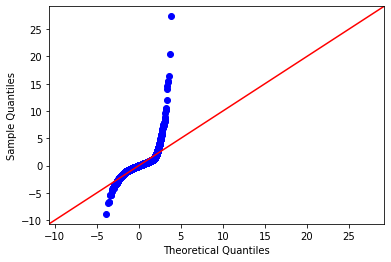

In [149]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

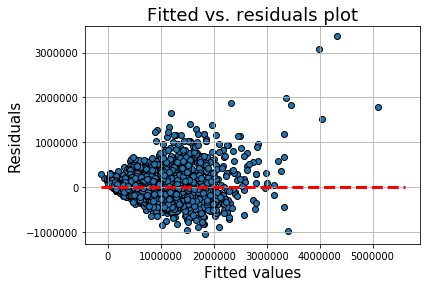

In [150]:
p=plt.scatter(x=model_poly_features.fittedvalues,y=model_poly_features.resid,edgecolor='k')
xmin=min(model_poly_features.fittedvalues)
xmax = max(model_poly_features.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

In [151]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 
          'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]',
         'had_reno*yr_updated_(1954.0, 1977.0]', 'had_reno*yr_updated_(1977.0, 1999.0]', 'had_reno*yr_updated_(1999.0, 2015.0]',
         'sqft_above_scaled*sqft_living15_scaled', 'sqft_above_scaled*bedrooms_scaled', 
          'sqft_above_scaled*floors_scaled', 'sqft_above_scaled*grade', 'sqft_above_scaled*sqft_lot',
         'bedrooms*grade']

X_train_cols = [col for col in X_train_poly_features.columns if col not in m_cols]

In [152]:
BidirectionalStepwiseSelection(X_train_poly_features[X_train_cols], y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : grade^3 	AIC : 478597.49242815876
break : No need to Backward Elimination
Entered : bathrooms_scaled 	AIC : 476695.173307348
break : No need to Backward Elimination
Entered : house_age 	AIC : 474631.15948326787
break : No need to Backward Elimination
Entered : _98004 	AIC : 473101.19616611925
break : No need to Backward Elimination
Entered : urban__1 	AIC : 471106.80423114134
break : No need to Backward Elimination
Entered : view__4 	AIC : 469657.5846133875
break : No need to Backward Elimination
Entered : sqft_living15_scaled 	AIC : 467798.7202451348
break : No need to Backward Elimination
Entered : dist_from_city 	AIC : 466608.496695038
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 465390.7959942043
break : No need to Backward Elimination
Entered : _98039 	AIC : 464385.33932462113
break : No need to Backward Elimination
Entered : waterfront

(['intercept',
  'grade^3',
  'bathrooms_scaled',
  'house_age',
  '_98004',
  'urban__1',
  'view__4',
  'sqft_living15_scaled',
  'dist_from_city',
  'sqft_above_scaled',
  '_98039',
  'waterfront__1',
  '_98040',
  '_98112',
  'has_basement__1',
  'dist_from_city*waterfront__1',
  'view__3',
  'grade^2',
  'grade_scaled',
  '_98117',
  'condition_5',
  'view__2',
  '_98105',
  '_98103',
  '_98119',
  '_98115',
  '_98199',
  '_98102',
  '_98033',
  '_98109',
  '_98107',
  'view__1',
  'condition_4',
  'bathrooms_scaled*bedrooms_scaled',
  '_98029',
  'sqft_lot',
  'had_reno__1',
  '_98177',
  '_98122',
  'floors_scaled*split_level__1',
  '_98045',
  '_98006',
  '_98178',
  '_98116',
  '_98136',
  '_98027',
  '_98144',
  '_98005',
  'season__1',
  '_98133',
  '_98125',
  '_98022',
  'new_build__1',
  '_98008',
  '_98058',
  'season__1*waterfront__1',
  '_98053',
  '_98052',
  '_98065',
  '_98168',
  '_98075',
  '_98007',
  '_98126',
  '_98024',
  '_98038',
  '_98010',
  '_98074',
  '_

## Re-Run Polynomial Model

### Define Features

In [158]:
# columns chosen by stepwise selection
cols_to_include = ['grade^3', 'bathrooms_scaled', 'house_age', '_98004', 'urban__1', 'view__4', 'sqft_living15_scaled', 'dist_from_city', 'sqft_above_scaled', '_98039', 'waterfront__1', '_98040', '_98112', 'has_basement__1', 'dist_from_city*waterfront__1', 'view__3', 'grade^2', 'grade_scaled', '_98117', 'condition_5', 'view__2', '_98105', '_98103', '_98119', '_98115', '_98199', '_98102', '_98033', '_98109', '_98107', 'view__1', 'condition_4', 'bathrooms_scaled*bedrooms_scaled', '_98029', 'sqft_lot', 'had_reno__1', '_98177', '_98122', 'floors_scaled*split_level__1', '_98045', '_98006', '_98178', '_98116', '_98136', '_98027', '_98144', '_98005', 'season__1', '_98133', '_98125', '_98022', 'new_build__1', '_98008', '_98058', 'season__1*waterfront__1', '_98053', '_98052', '_98065', '_98168', '_98075', '_98007', '_98126', '_98024', '_98038', '_98010', '_98074', '_98155', '_98034', '_98072', '_98118', '_98070', '_98014', 'split_level__1', '_98028']
# columns to add back because of interactions that are significant
cols_to_add = ['bedrooms_scaled', 'floors_scaled']
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [159]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [160]:
X_train_poly_features_rerun = X_train_poly_features[cols_to_include]
X_test_poly_features_rerun = X_test_poly_features[cols_to_include]

### Linear Regression sklearn

In [161]:
lin_reg_sklearn(X_train_poly_features_rerun, X_test_poly_features_rerun, y_train, y_test)

Training Set RMSE: 147820.68970206904
Test Set RMSE: 147473.9984884369
Cross Val RMSE: 150297.92412021657


### Linear Regression statsmodels

In [162]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1156.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        18:34:46   Log-Likelihood:            -2.2826e+05
No. Observations:               17133   AIC:                         4.567e+05
Df Residuals:                   17056   BIC:                         4.573e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.894e+05   8029.607     48.501      0.000    3.74e+05    4.05e+05
_98004                            6.205e+05    1.1e+04     56.352      0.000    5.99e+05    6.42e+05
_98005                            1.588e+05   1.37e+04     11.555      0.000    1.32e+05    1.86e+05
_98006                            1.338e+05   8540.962     15.670      0.000    1.17e+05    1.51e+05
_98007                            1.136e+05   1.55e+04      7.347      0.000    8.33e+04    1.44e+05
_98008                            1.136e+05   1.11e+04     10.235      0.000    9.19e+04    1.35e+05
_98010                            7.186e+04   1.73e+04      4.147      0.000    3.79e+04    1.06e+05
_98014                            5.357e+04   1.54e+04      3.484      0.000    2.34e+04    8.37e+04
_98022                            6.237e+04   1.25e+04      5.008      0.000     3.8e+04    8.68e+04
_98024                            1.073e+05   1.99e+04      5.381      0.000    6.82e+04    1.46e+05
_98027                            9.799e+04   8755.470     11.192      0.000    8.08e+04    1.15e+05
_98028                            2.435e+04   1.04e+04      2.337      0.019    3926.165    4.48e+04
_98029                            1.544e+05   9878.388     15.626      0.000    1.35e+05    1.74e+05
_98033                             1.99e+05   9699.617     20.518      0.000     1.8e+05    2.18e+05
_98034                            5.451e+04   8747.433      6.231      0.000    3.74e+04    7.17e+04
_98038                             3.77e+04   7439.348      5.068      0.000    2.31e+04    5.23e+04
_98039                            1.164e+06   2.47e+04     47.119      0.000    1.12e+06    1.21e+06
_98040                            3.616e+05    1.1e+04     32.767      0.000     3.4e+05    3.83e+05
_98045                            1.163e+05   1.19e+04      9.794      0.000     9.3e+04     1.4e+05
_98052                            8.895e+04   8885.917     10.010      0.000    7.15e+04    1.06e+05
_98053                            8.956e+04   9329.524      9.600      0.000    7.13e+04    1.08e+05
_98058                           -2.063e+04   7935.536     -2.599      0.009   -3.62e+04   -5071.460
_98065                            6.655e+04   9981.872      6.667      0.000     4.7e+04    8.61e+04
_98070                            6.711e+04   1.69e+04      3.977      0.000     3.4e+04       1e+05
_98072                             5.91e+04   1.06e+04      5.598      0.000    3.84e+04    7.98e+04
_98074                            5.907e+04   9011.958      6.555      0.000    4.14e+04    7.67e+04
_98075                            7.046e+04   9583.941      7.351      0.000    5.17e+04    8.92e+04
_98102                            3.607e+05   1.69e+0

### Summary

The model with added polynomial features, showed a small improvement in R^2 and RSME